### Import Python Libraries and clone Github repository



In [ ]:
# Run this initially
import os
import numpy as np
import scipy.io.wavfile
from scipy.fftpack import dct
import matplotlib.pyplot as plt
from scipy import signal
from scipy.sparse import lil_matrix
from scipy.signal import spectrogram
from scipy.signal import get_window

# Github method (Run this once)

!git clone https://github.com/antanandia33/Speaker_Recognition_EEC_201_Project
%cd Speaker_Recognition_EEC_201_Project

Cloning into 'Speaker_Recognition_EEC_201_Project'...
remote: Enumerating objects: 319, done.
remote: Counting objects: 100% (319/319), done.
remote: Compressing objects: 100% (303/303), done.
remote: Total 319 (delta 61), reused 71 (delta 12), pack-reused 0 (from 0)
Receiving objects: 100% (319/319), 18.23 MiB | 14.82 MiB/s, done.
Resolving deltas: 100% (61/61), done.
/content/Speaker_Recognition_EEC_201_Project/Speaker_Recognition_EEC_201_Project


### Test 2: Audio Signal Plots and Spectrograms
The sampling rate is 12500 Hz. There were 20.48 milliseconds of speech contained in a block of 256 samples.

Sample rate =  12500  Hz
20.48  milliseconds in a block of 256 samples


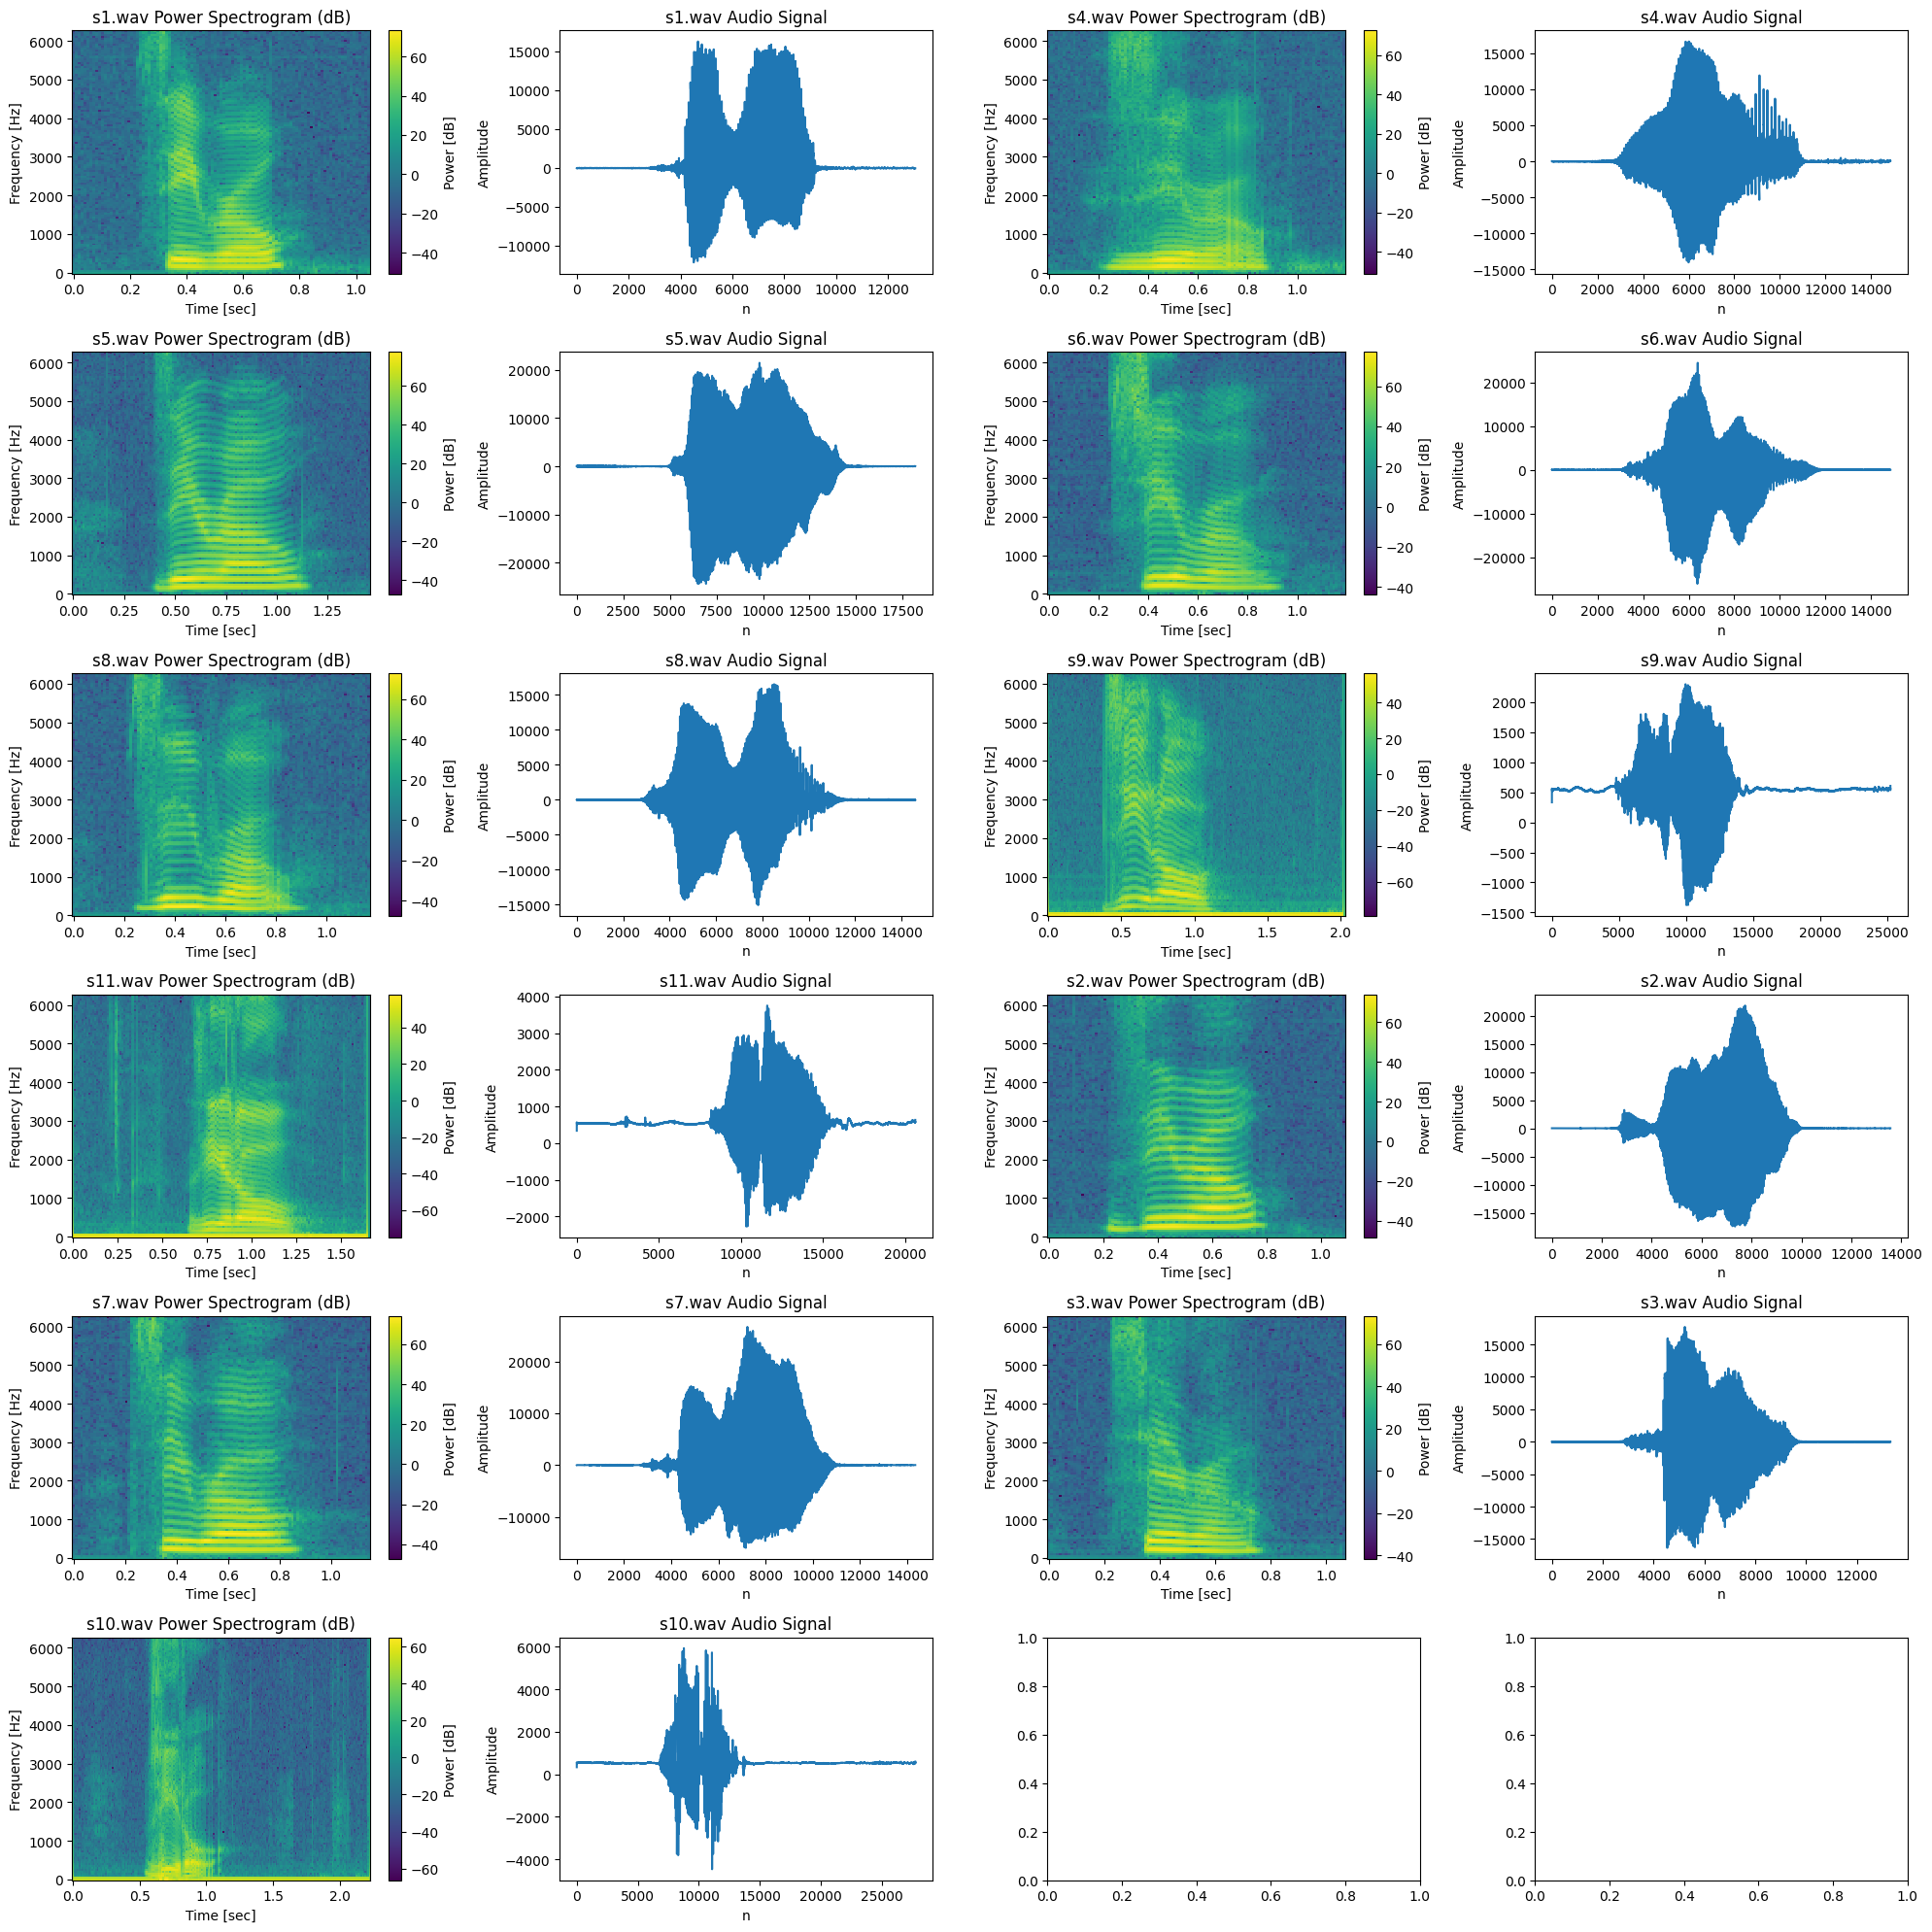

In [ ]:
train_folder_path = '/content/Speaker_Recognition_EEC_201_Project/Training_Data'

train_speakers = []

# verify files and put filenames in train_speakers array
for filename in os.listdir(train_folder_path):
    file_path = os.path.join(train_folder_path, filename)
    if os.path.isfile(file_path):  # Ensure it's a file, not a directory
        train_speakers.append(filename)

num_files = len(train_speakers)
num_cols = 4
num_rows = int(np.ceil(num_files / 2))
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 20))

row = 0
col = 0
for speaker in train_speakers:
    file_path = os.path.join(train_folder_path, speaker)

    # Get sample rate and sample values from signal
    sample_rate, sig = scipy.io.wavfile.read(file_path)  # File assumed to be in the same directory

    # # of milliseconds of speech in 256 samples
    samp256_len = 256 / sample_rate * 1000

    # Check if .wav file is stereo audio (2 signals)
    if len(np.shape(sig)) == 2:
      sig = sig[:, 0]   # Get left channel data

    # Find STFT of signal
    N = 256
    M = N//3
    f, t_spec, Sxx = signal.stft(sig, fs=sample_rate, nperseg = N)
    spect = np.abs(Sxx)
    log_power_spect = 10*np.log10(spect ** 2 + 1e-10)

    # Plot Spectrogram of signal
    pcm1 = axes[row, 2*col].pcolormesh(t_spec, f, log_power_spect, shading = 'auto')
    axes[row, 2*col].set_ylabel('Frequency [Hz]')
    axes[row, 2*col].set_xlabel('Time [sec]')
    axes[row, 2*col].set_title(speaker + ' Power Spectrogram (dB)')
    fig.colorbar(pcm1, ax=axes[row, 2*col], label='Power [dB]')

    # plot signal
    axes[row, (2*col) + 1].plot(sig)
    axes[row, (2*col) + 1].set_title(speaker + " Audio Signal")
    axes[row, (2*col) + 1].set_xlabel("n")
    axes[row, (2*col) + 1].set_ylabel("Amplitude")

    if (col == 1):
      row += 1
      col = 0
    else:
      col += 1

print("Sample rate = ", sample_rate, " Hz")
print(samp256_len, " milliseconds in a block of 256 samples")
plt.tight_layout()


### Test 3: Mel-spaced filter bank responses

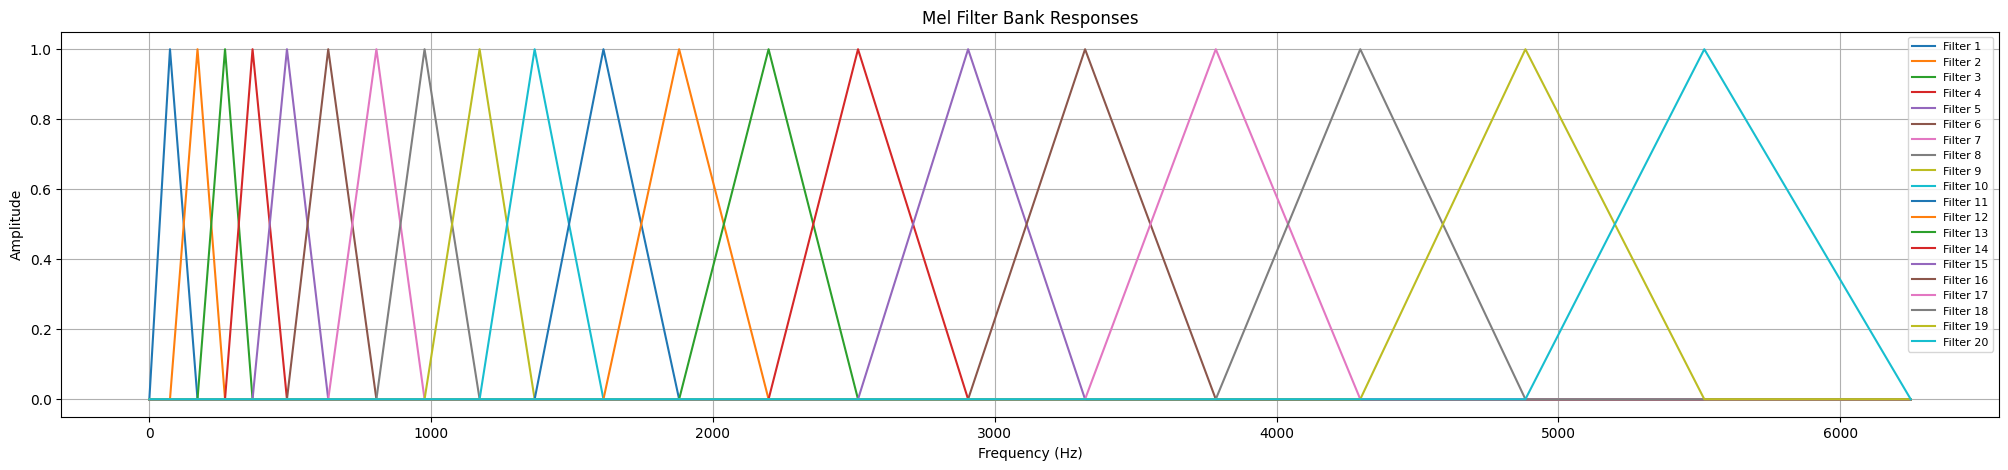

In [ ]:
# Test 3: from website: FFT and Filter Banks (melfb function)
# Pre Emphasis / Framing / Windowing
pre_emphasis = 0.97
emphasized_sig = np.append(sig[0], sig[1:] - pre_emphasis * sig[:-1])

# Framing
frame_size = 0.02048
frame_stride = frame_size/3

frame_length, frame_step = frame_size * sample_rate, frame_stride * sample_rate  # Convert from seconds to samples
signal_length = len(emphasized_sig)
frame_length = int(round(frame_length))
frame_step = int(round(frame_step))
num_frames = int(np.ceil(float(np.abs(signal_length - frame_length)) / frame_step))  # Make sure that we have at least 1 frame

pad_signal_length = num_frames * frame_step + frame_length
z = np.zeros((pad_signal_length - signal_length))
pad_signal = np.append(emphasized_sig, z) # Pad Signal to make sure that all frames have equal number of samples without truncating any samples from the original signal

indices = np.tile(np.arange(0, frame_length), (num_frames, 1)) + np.tile(np.arange(0, num_frames * frame_step, frame_step), (frame_length, 1)).T
frames = pad_signal[indices.astype(np.int32, copy=False)]

# Window
frames *= np.hamming(frame_length)

# FFT and Power Spectrum
NFFT = 512
mag_frames = np.absolute(np.fft.rfft(frames, NFFT))  # Magnitude of the FFT
pow_frames = ((1.0 / NFFT) * ((mag_frames) ** 2))  # Power Spectrum

# Parameters
nfilt = 20  # Number of Mel filters
low_freq = 0  # Low frequency (in Hz)
high_freq = sample_rate / 2  # High frequency (Nyquist frequency)

# Convert to Mel scale
low_freq_mel = 0
high_freq_mel = (2595 * np.log10(1 + (high_freq / 700)))  # Convert Nyquist frequency to Mel scale
mel_points = np.linspace(low_freq_mel, high_freq_mel, nfilt + 2)  # Equally spaced in Mel scale
hz_points = (700 * (10**(mel_points / 2595) - 1))  # Convert Mel back to Hz

# Compute the bin indices for the Mel frequencies
bin = np.floor((NFFT + 1) * hz_points / sample_rate)

# Initialize the Mel filter bank (nfilt x (NFFT / 2 + 1))
fbank = np.zeros((nfilt, int(np.floor(NFFT / 2 + 1))))

# Build the triangular filters
for m in range(1, nfilt + 1):
    f_m_minus = int(bin[m - 1])   # Left boundary of the filter
    f_m = int(bin[m])             # Center of the filter
    f_m_plus = int(bin[m + 1])    # Right boundary of the filter

    for k in range(f_m_minus, f_m):
        fbank[m - 1, k] = (k - bin[m - 1]) / (bin[m] - bin[m - 1])  # Left side of the triangle

    for k in range(f_m, f_m_plus):
        fbank[m - 1, k] = (bin[m + 1] - k) / (bin[m + 1] - bin[m])  # Right side of the triangle

filter_banks = np.dot(pow_frames, fbank.T)
filter_banks = np.where(filter_banks == 0, np.finfo(float).eps, filter_banks)  # Numerical Stability
filter_banks = 20 * np.log10(filter_banks)  # dB
filter_banks -= (np.mean(filter_banks, axis=0) + 1e-8)    # Mean Normalization of filter banks

# Time axis
times = np.arange(0, num_frames) * frame_stride

# Frequency axis (convert Mel filter centers to Hz)
hz_points_plot = hz_points[1:-1]  # Ignore the first and last points to match Mel filter bank size

plt.figure(figsize=(25, 5))

# Plot each filter
for i in range(fbank.shape[0]):
    plt.plot(np.linspace(0, sample_rate / 2, fbank.shape[1]), fbank[i, :], label=f'Filter {i+1}')

# Labels and title
plt.title("Mel Filter Bank Responses")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
plt.grid(True)
plt.legend(loc='upper right', fontsize=8)

### Test 3: Spectrograms before and after mel-frequency wrapping step

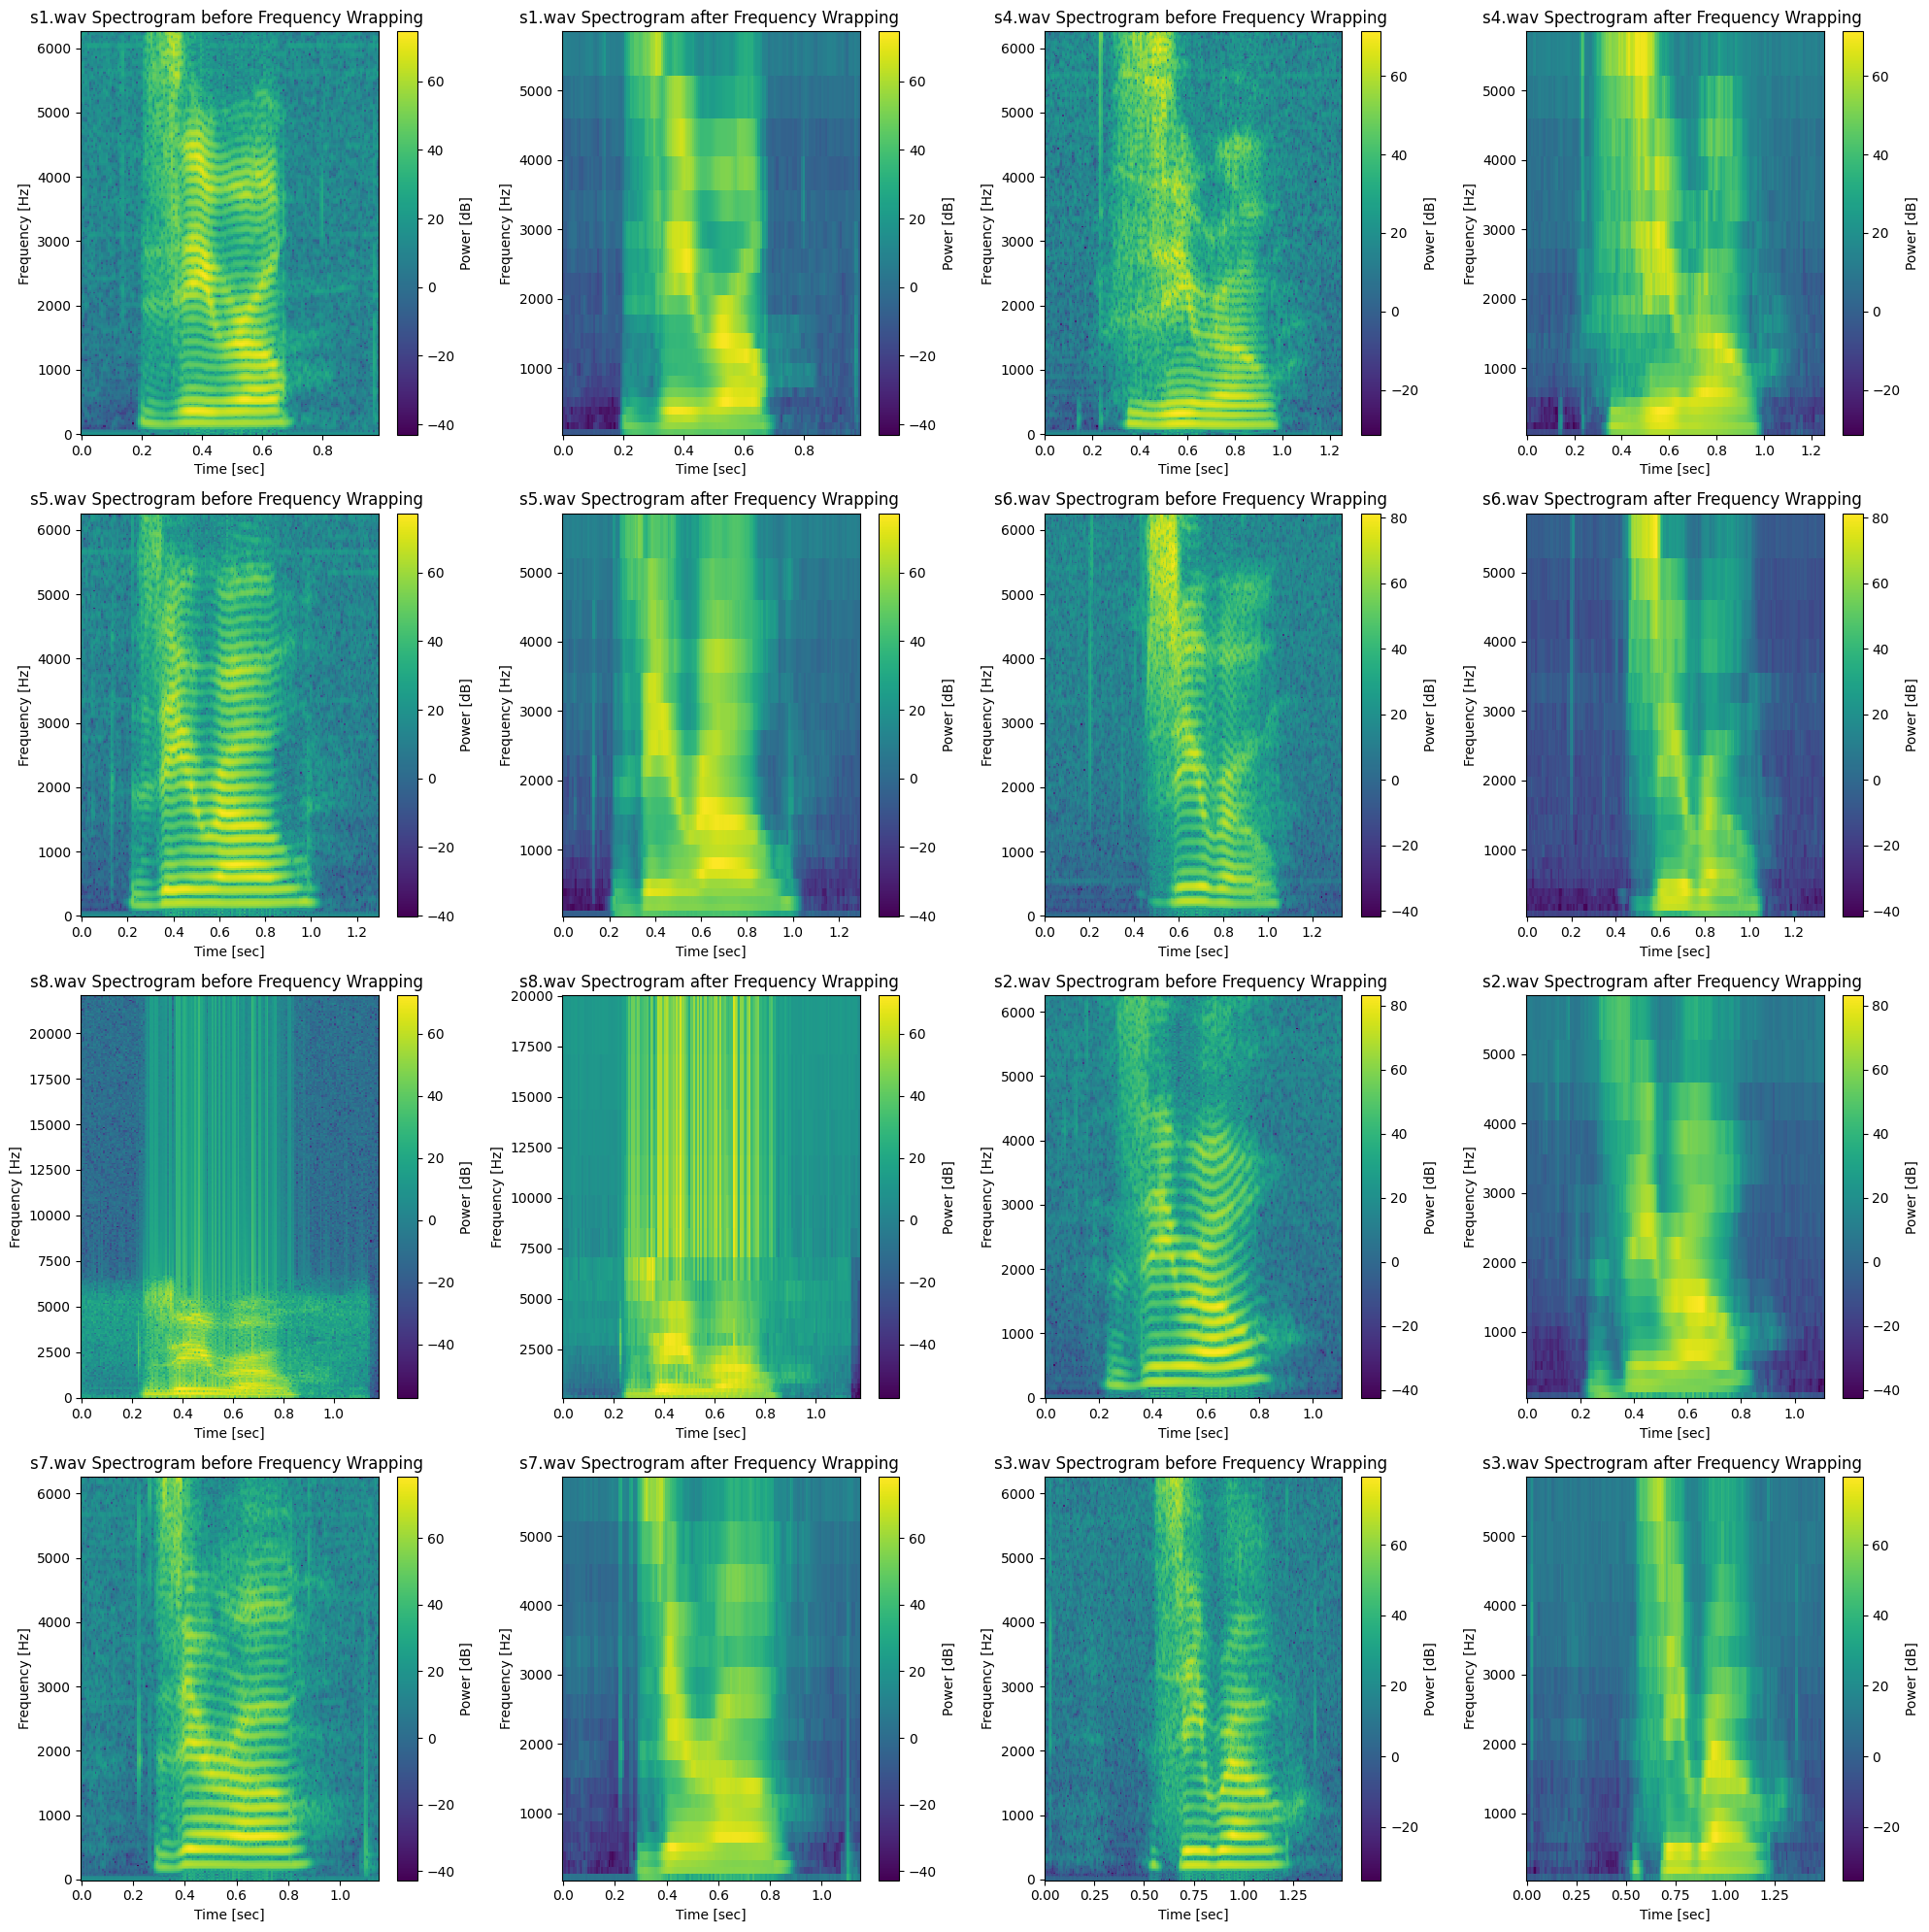

In [ ]:
# Before and after Mel frequency wrapping

train_folder_path = '/content/Speaker_Recognition_EEC_201_Project/Test_Data'

train_speakers = []

# verify files and put filenames in train_speakers array
for filename in os.listdir(train_folder_path):
    file_path = os.path.join(train_folder_path, filename)
    if os.path.isfile(file_path):  # Ensure it's a file, not a directory
        train_speakers.append(filename)

num_files = len(train_speakers)
num_cols = 4
num_rows = int(np.ceil(num_files / 2))
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 20))

row = 0
col = 0
for speaker in train_speakers:
    file_path = os.path.join(train_folder_path, speaker)

    # Get sample rate and sample values from signal
    sample_rate, sig = scipy.io.wavfile.read(file_path)  # File assumed to be in the same directory

    # Check if .wav file is stereo audio (2 signals)
    if len(np.shape(sig)) == 2:
      sig = sig[:, 0]   # Get left channel data

    N = 256   # Segment length
    M = N//3  # Segment overlap (overlap by N-M samples)

    # Pre Emphasis
    pre_emphasis = 0.97
    emphasized_sig = np.append(sig[0], sig[1:] - pre_emphasis * sig[:-1])

    N = 512
    M = N//3

    # Framing
    frame_size = 0.02048
    frame_stride = frame_size/3

    frame_length, frame_step = frame_size * sample_rate, frame_stride * sample_rate  # Convert from seconds to samples
    signal_length = len(emphasized_sig)
    frame_length = int(round(frame_length))
    frame_step = int(round(frame_step))
    num_frames = int(np.ceil(float(np.abs(signal_length - frame_length)) / frame_step))  # Make sure that we have at least 1 frame

    pad_signal_length = num_frames * frame_step + frame_length
    z = np.zeros((pad_signal_length - signal_length))
    pad_signal = np.append(emphasized_sig, z) # Pad Signal to make sure that all frames have equal number of samples without truncating any samples from the original signal

    indices = np.tile(np.arange(0, frame_length), (num_frames, 1)) + np.tile(np.arange(0, num_frames * frame_step, frame_step), (frame_length, 1)).T
    frames = pad_signal[indices.astype(np.int32, copy=False)]

    # Window
    frames *= np.hamming(frame_length)

    # FFT and Power Spectrum
    NFFT = 512
    mag_frames = np.absolute(np.fft.rfft(frames, NFFT))  # Magnitude of the FFT
    pow_frames = ((1.0 / NFFT) * ((mag_frames) ** 2))  # Power Spectrum

    # Parameters
    nfilt = 20  # Number of Mel filters
    low_freq = 0  # Low frequency (in Hz)
    high_freq = sample_rate / 2  # High frequency (Nyquist frequency)

    # Convert to Mel scale (melfb)
    low_freq_mel = 0
    high_freq_mel = (2595 * np.log10(1 + (high_freq / 700)))  # Convert Nyquist frequency to Mel scale
    mel_points = np.linspace(low_freq_mel, high_freq_mel, nfilt + 2)  # Equally spaced in Mel scale
    hz_points = (700 * (10**(mel_points / 2595) - 1))  # Convert Mel back to Hz

    # Compute the bin indices for the Mel frequencies
    bin = np.floor((NFFT + 1) * hz_points / sample_rate)

    # Initialize the Mel filter bank (nfilt x (NFFT / 2 + 1))
    fbank = np.zeros((nfilt, int(np.floor(NFFT / 2 + 1))))

    # Build the triangular filters
    for m in range(1, nfilt + 1):
        f_m_minus = int(bin[m - 1])   # Left boundary of the filter
        f_m = int(bin[m])             # Center of the filter
        f_m_plus = int(bin[m + 1])    # Right boundary of the filter

        for k in range(f_m_minus, f_m):
            fbank[m - 1, k] = (k - bin[m - 1]) / (bin[m] - bin[m - 1])  # Left side of the triangle

        for k in range(f_m, f_m_plus):
            fbank[m - 1, k] = (bin[m + 1] - k) / (bin[m + 1] - bin[m])  # Right side of the triangle

    filter_banks = np.dot(pow_frames, fbank.T)
    filter_banks = np.where(filter_banks == 0, np.finfo(float).eps, filter_banks)  # Numerical Stability
    filter_banks = 20 * np.log10(filter_banks)  # dB
    filter_banks -= (np.mean(filter_banks, axis=0) + 1e-8)    # Mean Normalization of filter banks

    # Time axis
    times = np.arange(0, num_frames) * frame_stride

    # Frequency axis (convert Mel filter centers to Hz)
    hz_points_plot = hz_points[1:-1]  # Ignore the first and last points to match Mel filter bank size

    # Plot Spectrogram before frequency wrapping
    pcm1 = axes[row, 2*col].pcolormesh(times, np.linspace(0, sample_rate / 2, NFFT // 2 + 1), 10 * np.log10(pow_frames.T), shading = 'auto')
    axes[row, 2*col].set_ylabel('Frequency [Hz]')
    axes[row, 2*col].set_xlabel('Time [sec]')
    axes[row, 2*col].set_title(speaker + ' Spectrogram before Frequency Wrapping ')
    fig.colorbar(pcm1, ax=axes[row, 2*col], label='Power [dB]')

    # Plot Spectrogram after frequency wrapping
    pcm2 = axes[row, (2*col) + 1].pcolormesh(times, hz_points_plot, filter_banks.T, shading = 'auto')
    axes[row, (2*col) + 1].set_ylabel('Frequency [Hz]')
    axes[row, (2*col) + 1].set_xlabel('Time [sec]')
    axes[row, (2*col) + 1].set_title(speaker + ' Spectrogram after Frequency Wrapping ')
    fig.colorbar(pcm1, ax=axes[row, (2*col) + 1], label='Power [dB]')

    if (col == 1):
      row += 1
      col = 0
    else:
      col += 1


plt.tight_layout()


Test 3: melfb function \\
The melfb function computes filter banks that are uniformly spaced on the mel scale. This is used to mimic the behavior of human hearing, in which frequencies are perceived in the mel frequency scale with linear spacing below 1000 Hz and logarithmic spacing above 1000 Hz. \\
The DCT of these of these filter banks can be computed to find the Mel-Frequency Cepstrum Coefficients of the signal in order to train a model for feature matching.

In [ ]:
# Melfb function
def melfb(num_filts, fft_len, fs, pframes):
    # Parameters
    pow_frames = pframes
    sample_rate = fs
    NFFT = fft_len
    nfilt = num_filts  # Number of Mel filters

    low_freq = 0  # Low frequency (in Hz)
    high_freq = sample_rate / 2  # High frequency (Nyquist frequency)

    # Convert to Mel scale (melfb)
    low_freq_mel = 0
    high_freq_mel = (2595 * np.log10(1 + (high_freq / 700)))  # Convert Nyquist frequency to Mel scale
    mel_points = np.linspace(low_freq_mel, high_freq_mel, nfilt + 2)  # Equally spaced in Mel scale
    hz_points = (700 * (10**(mel_points / 2595) - 1))  # Convert Mel back to Hz

    # Compute the bin indices for the Mel frequencies
    bin = np.floor((NFFT + 1) * hz_points / sample_rate)

    # Initialize the Mel filter bank (nfilt x (NFFT / 2 + 1))
    fbank = np.zeros((nfilt, int(np.floor(NFFT / 2 + 1))))

    # Build the triangular filters
    for m in range(1, nfilt + 1):
        f_m_minus = int(bin[m - 1])   # Left boundary of the filter
        f_m = int(bin[m])             # Center of the filter
        f_m_plus = int(bin[m + 1])    # Right boundary of the filter

        for k in range(f_m_minus, f_m):
            fbank[m - 1, k] = (k - bin[m - 1]) / (bin[m] - bin[m - 1])  # Left side of the triangle

        for k in range(f_m, f_m_plus):
            fbank[m - 1, k] = (bin[m + 1] - k) / (bin[m + 1] - bin[m])  # Right side of the triangle

    filter_banks = np.dot(pow_frames, fbank.T)
    filter_banks = np.where(filter_banks == 0, np.finfo(float).eps, filter_banks)  # Numerical Stability
    filter_banks = 20 * np.log10(filter_banks)  # dB
    filter_banks -= (np.mean(filter_banks, axis=0) + 1e-8)    # Mean Normalization of filter banks

    return filter_banks

Test 4: MFCC function

In [ ]:
def mfcc (filepath):
  # Get sample rate and sample values from signal
  sample_rate, sig = scipy.io.wavfile.read(filepath)  # File assumed to be in the same directory
  if len(sig.shape) > 1:
    sig = np.mean(sig, axis=1)

  f, t_spec, Sxx = signal.stft(sig, fs=sample_rate, nperseg = N)
  spect = np.abs(Sxx)
  log_power_spect = 10*np.log10(spect ** 2 + 1e-10)

  # Pre Emphasis
  pre_emphasis = 0.97
  emphasized_sig = np.append(sig[0], sig[1:] - pre_emphasis * sig[:-1])

  # Framing
  frame_size = 0.02048
  frame_stride = frame_size/3

  frame_length, frame_step = frame_size * sample_rate, frame_stride * sample_rate  # Convert from seconds to samples
  signal_length = len(emphasized_sig)
  frame_length = int(round(frame_length))
  frame_step = int(round(frame_step))
  num_frames = int(np.ceil(float(np.abs(signal_length - frame_length)) / frame_step))  # Make sure that we have at least 1 frame

  pad_signal_length = num_frames * frame_step + frame_length
  z = np.zeros((pad_signal_length - signal_length))
  pad_signal = np.append(emphasized_sig, z) # Pad Signal to make sure that all frames have equal number of samples without truncating any samples from the original signal

  indices = np.tile(np.arange(0, frame_length), (num_frames, 1)) + np.tile(np.arange(0, num_frames * frame_step, frame_step), (frame_length, 1)).T
  frames = pad_signal[indices.astype(np.int32, copy=False)]

  # Window
  frames *= np.hamming(frame_length)

  # FFT and Power Spectrum
  NFFT = 512
  mag_frames = np.absolute(np.fft.rfft(frames, NFFT))  # Magnitude of the FFT
  pow_frames = ((1.0 / NFFT) * ((mag_frames) ** 2))  # Power Spectrum

  # Parameters
  nfilt = 20  # Number of Mel filters
  low_freq = 0  # Low frequency (in Hz)
  high_freq = sample_rate / 2  # High frequency (Nyquist frequency)


  # Apply mel frequency wrapping to STFT of signal
  filter_banks = melfb(nfilt, NFFT, sample_rate, pow_frames)

  # Time axis
  times = np.arange(0, num_frames) * frame_stride

  # Frequency axis (convert Mel filter centers to Hz)
  hz_points_plot = hz_points[1:-1]  # Ignore the first and last points to match Mel filter bank size

  # Cepstrum coefficients
  num_ceps = 19
  cep_lifter = 3

  cep_coeff = dct(filter_banks, type=2, axis=1, norm='ortho')[:, 1 : (num_ceps + 1)] # Keep 2-13

  (nframes, ncoeff) = cep_coeff.shape
  n = np.arange(ncoeff)
  lift = 1 + (cep_lifter / 2) * np.sin(np.pi * n / cep_lifter)
  cep_coeff *= lift

  # Mean Normalization of MFCC coefficients
  cep_coeff -= (np.mean(cep_coeff, axis=0) + 1e-8)

  return cep_coeff

## Part C - Vector Quantization

#### Test 5

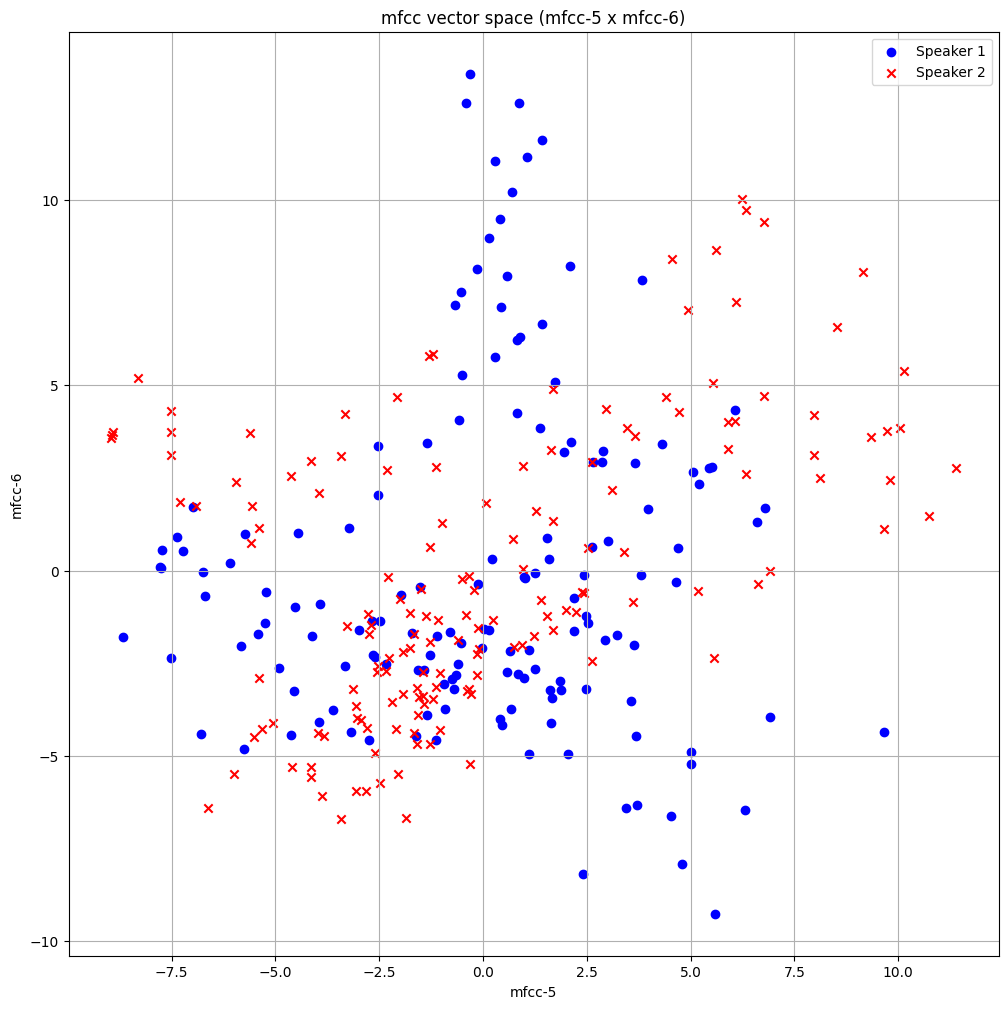

In [ ]:
# Plot mfcc
# Test 5

speaker_1_mfcc = mfcc("/content/Speaker_Recognition_EEC_201_Project/Training_Data/s1.wav")
speaker_2_mfcc = mfcc("/content/Speaker_Recognition_EEC_201_Project/Training_Data/s2.wav")

# get the 5th and 6th coefficients of speaker 1 and 2
x1, y1 = speaker_1_mfcc[:, 4], speaker_1_mfcc[:, 5]
x2, y2 = speaker_2_mfcc[:, 4], speaker_2_mfcc[:, 5]

plt.figure(figsize=(12, 12))
plt.scatter(x1, y1, color='blue', marker='o', label='Speaker 1')
plt.scatter(x2, y2, color='red', marker='x', label='Speaker 2')
plt.xlabel('mfcc-5')
plt.ylabel('mfcc-6')
plt.title('mfcc vector space (mfcc-5 x mfcc-6)')
plt.legend()
plt.grid(True)

### Train using LGB

In [ ]:
# LGB Algorithm
def LGB(features, centroids, epsilon):
  """
  inputs
  features - NxM array frames x features
  centroids - Number of Centroids/Clusters
  epsilon - threshold for convergence

  output
  codebook - NxM array of centroids x features
  """

  # Initialize with a single-vector codebook
  codebook = np.array([np.mean(features, axis=0)])

  # while the size of the codebook is less than the wanted number of centroids
  while len(codebook) < centroids:

    # Split centroids
    new_codebook = []
    for code_vector in codebook:
        new_codebook.append(code_vector + epsilon)
        new_codebook.append(code_vector - epsilon)

    new_codebook = np.array(new_codebook)

    codebook = new_codebook

    previous_distortion = np.sum((features - codebook[0, :]) ** 2) / features.shape[0]

    # nearest neighbor search
    while True:
        distances = np.linalg.norm(features[:, np.newaxis, :] - codebook, axis=2)
        labels = np.argmin(distances, axis=1)

        new_codebook = []
        for i in range(len(codebook)):
            if np.any(labels == i):
                new_codebook.append(features[labels == i].mean(axis=0))
            else:
                new_codebook.append(codebook[i])
        new_codebook = np.array(new_codebook)

        # compute distortion
        distortion = np.mean(np.min(distances, axis=1))

        # break if average distortion falls below epsilon
        if abs(previous_distortion - distortion) / distortion < epsilon:
          break
        previous_distortion = distortion
        codebook = new_codebook

  return codebook

### Test 6

#### Train Function

In [ ]:
# runs LGB on every speaker mfcc and generates a codebook
# returns a list of codebooks
def train(speaker_mfccs, centroids, eps):
  codebookList = []
  for speaker in speaker_mfccs:
    codebook = LGB(speaker, centroids, eps)
    codebookList.append(codebook)
  return codebookList

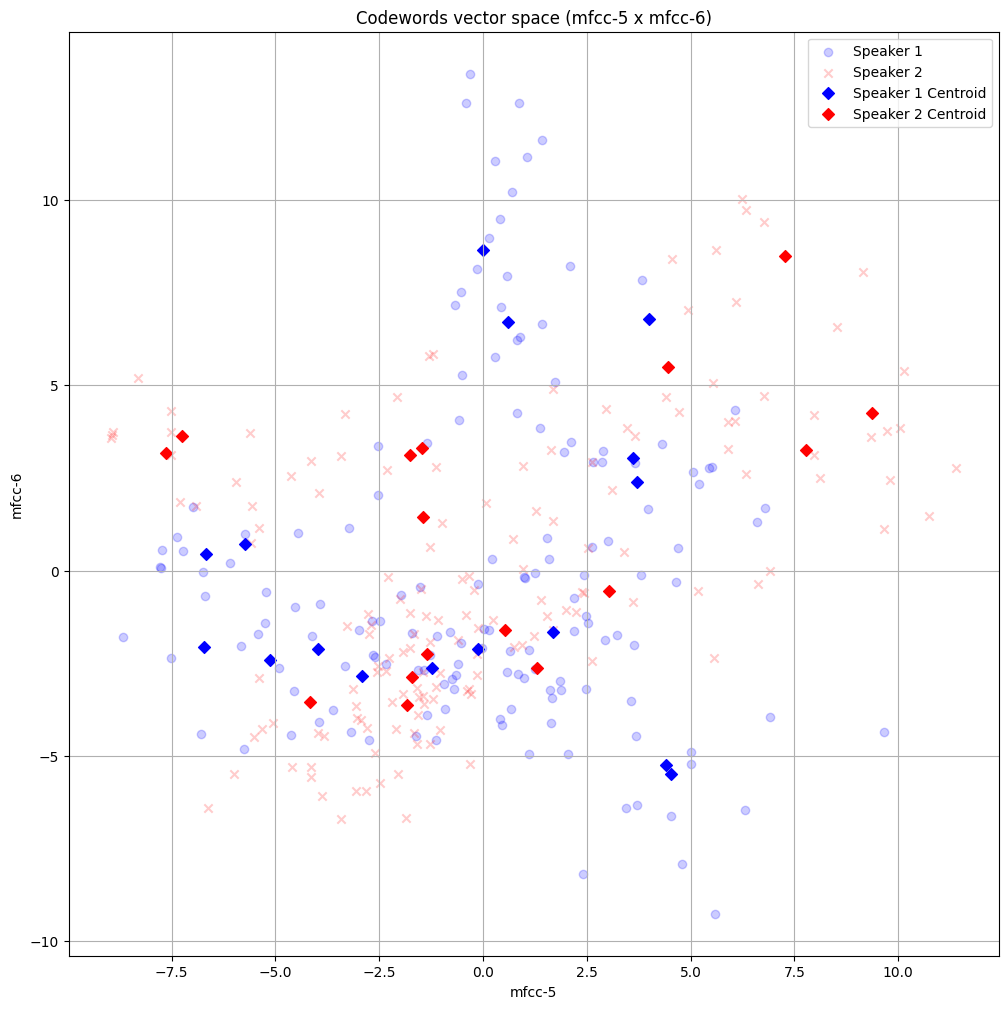

In [ ]:
# Test 6
speaker_1_mfcc = mfcc("/content/Speaker_Recognition_EEC_201_Project/Training_Data/s1.wav")
speaker_2_mfcc = mfcc("/content/Speaker_Recognition_EEC_201_Project/Training_Data/s2.wav")

# get the 5th and 6th coefficients
x1, y1 = speaker_1_mfcc[:, 4], speaker_1_mfcc[:, 5]
x2, y2 = speaker_2_mfcc[:, 4], speaker_2_mfcc[:, 5]

plt.figure(figsize=(12, 12))
plt.scatter(x1, y1, color='blue', marker='o', label='Speaker 1', alpha=0.2)
plt.scatter(x2, y2, color='red', marker='x', label='Speaker 2', alpha=0.2)

# train
codebookList = train([speaker_1_mfcc, speaker_2_mfcc], 16, 0.01)

# get the 5th and 6th dimensions of the centroids
x1, y1 = codebookList[0][:, 4], codebookList[0][:, 5]
x2, y2 = codebookList[1][:, 4], codebookList[1][:, 5]

plt.scatter(x1, y1, color='blue', marker='D', label='Speaker 1 Centroid')
plt.scatter(x2, y2, color='red', marker='D', label='Speaker 2 Centroid')

plt.xlabel('mfcc-5')
plt.ylabel('mfcc-6')
plt.title('Codewords vector space (mfcc-5 x mfcc-6)')
plt.legend()
plt.grid(True)

## Part D

### Speaker Prediction Function

In [ ]:
# For every codebook, calculate the average distance between the test_mfcc vectors and the code book centroids
# The test_mfcc codebook pair with the minimum average distance is the best match
# returns the index of the codebook with the best match
def predict(codebookList, test_mfcc):

  distances = np.array([])
  for codebook in codebookList:
    vector_centroid_distances = np.linalg.norm(test_mfcc[:, np.newaxis, :] - codebook, axis=2)
    avg_vector_centroid_distance = np.mean(np.min(vector_centroid_distances, axis=1))
    distances = np.append(distances, avg_vector_centroid_distance)

  return np.argmin(distances)


### Test 7

In [ ]:
# get mfccs for all train speakers
train_folder_path = '/content/Speaker_Recognition_EEC_201_Project/Training_Data'

train_speakers = []

for filename in os.listdir(train_folder_path):
    file_path = os.path.join(train_folder_path, filename)
    if os.path.isfile(file_path):  # Ensure it's a file, not a directory
        train_speakers.append(filename)

train_speaker_mfccs = []

for speaker in train_speakers:
  speaker_mfcc = mfcc(os.path.join(train_folder_path, speaker))
  train_speaker_mfccs.append(speaker_mfcc)


# train codebooks
codeBooks = train(train_speaker_mfccs, 16, 0.05)

# get mfccs for all test speakers
test_folder_path = '/content/Speaker_Recognition_EEC_201_Project/Test_Data'

test_speakers = []

for filename in os.listdir(test_folder_path):
    file_path = os.path.join(test_folder_path, filename)
    if os.path.isfile(file_path):
        test_speakers.append(filename)


test_speaker_mfccs = []

for speaker in test_speakers:
  speaker_mfcc = mfcc(os.path.join(test_folder_path, speaker))
  test_speaker_mfccs.append(speaker_mfcc)

# reference prediction with training speakers
num_correct_train = 0
for train_speaker, speaker_mfcc in enumerate(train_speaker_mfccs):
  prediction = predict(codeBooks, speaker_mfcc)
  if train_speakers[prediction] == train_speakers[train_speaker]:
    num_correct_train += 1
    print(f"CORRECT: train_speaker: {train_speakers[train_speaker]} predicted as: {train_speakers[prediction]}")
  else:
    print(f"INCORRECT: train_speaker: {train_speakers[train_speaker]} predicted as: {train_speakers[prediction]}")


print(f"Accuracy: {num_correct_train * 100 / len(train_speaker_mfccs)}%")

# prediction with test speakers
num_correct = 0
for test_speaker, speaker_mfcc in enumerate(test_speaker_mfccs):
  prediction = predict(codeBooks, speaker_mfcc)

  if train_speakers[prediction] == test_speakers[test_speaker]:
    num_correct += 1
    print(f"CORRECT: test_speaker: {test_speakers[test_speaker]} predicted as: {train_speakers[prediction]}")
  else:
    print(f"INCORRECT: test_speaker: {test_speakers[test_speaker]} predicted as: {train_speakers[prediction]}")


print(f"Accuracy: {num_correct * 100 / len(test_speaker_mfccs)}%")

CORRECT: train_speaker: s1.wav predicted as: s1.wav
CORRECT: train_speaker: s4.wav predicted as: s4.wav
CORRECT: train_speaker: s5.wav predicted as: s5.wav
CORRECT: train_speaker: s6.wav predicted as: s6.wav
CORRECT: train_speaker: s8.wav predicted as: s8.wav
CORRECT: train_speaker: s9.wav predicted as: s9.wav
CORRECT: train_speaker: s11.wav predicted as: s11.wav
CORRECT: train_speaker: s2.wav predicted as: s2.wav
CORRECT: train_speaker: s7.wav predicted as: s7.wav
CORRECT: train_speaker: s3.wav predicted as: s3.wav
CORRECT: train_speaker: s10.wav predicted as: s10.wav
Accuracy: 100.0%
CORRECT: test_speaker: s1.wav predicted as: s1.wav
CORRECT: test_speaker: s4.wav predicted as: s4.wav
CORRECT: test_speaker: s5.wav predicted as: s5.wav
CORRECT: test_speaker: s6.wav predicted as: s6.wav
CORRECT: test_speaker: s8.wav predicted as: s8.wav
CORRECT: test_speaker: s2.wav predicted as: s2.wav
CORRECT: test_speaker: s7.wav predicted as: s7.wav
INCORRECT: test_speaker: s3.wav predicted as: s5.w

In [ ]:
# Including the new teammates' recordings
# get mfccs for all train speakers
train_folder_path = '/content/Speaker_Recognition_EEC_201_Project/New Zero Training'

train_speakers = []

for filename in os.listdir(train_folder_path):
    file_path = os.path.join(train_folder_path, filename)
    if os.path.isfile(file_path):  # Ensure it's a file, not a directory
        train_speakers.append(filename)

train_speaker_mfccs = []

for speaker in train_speakers:
  speaker_mfcc = mfcc(os.path.join(train_folder_path, speaker))
  train_speaker_mfccs.append(speaker_mfcc)


# train codebooks
codeBooks = train(train_speaker_mfccs, 16, 0.05)

# get mfccs for all test speakers
test_folder_path = '/content/Speaker_Recognition_EEC_201_Project/New Zero Testing'

test_speakers = []

for filename in os.listdir(test_folder_path):
    file_path = os.path.join(test_folder_path, filename)
    if os.path.isfile(file_path):
        test_speakers.append(filename)


test_speaker_mfccs = []

for speaker in test_speakers:
  speaker_mfcc = mfcc(os.path.join(test_folder_path, speaker))
  test_speaker_mfccs.append(speaker_mfcc)

# reference prediction with training speakers
num_correct_train = 0
for train_speaker, speaker_mfcc in enumerate(train_speaker_mfccs):
  prediction = predict(codeBooks, speaker_mfcc)
  if train_speakers[prediction] == train_speakers[train_speaker]:
    num_correct_train += 1
    print(f"CORRECT: train_speaker: {train_speakers[train_speaker]} predicted as: {train_speakers[prediction]}")
  else:
    print(f"INCORRECT: train_speaker: {train_speakers[train_speaker]} predicted as: {train_speakers[prediction]}")


print(f"Accuracy: {num_correct_train * 100 / len(train_speaker_mfccs)}%")

# prediction with test speakers
num_correct = 0
for test_speaker, speaker_mfcc in enumerate(test_speaker_mfccs):
  prediction = predict(codeBooks, speaker_mfcc)

  if train_speakers[prediction] == test_speakers[test_speaker]:
    num_correct += 1
    print(f"CORRECT: test_speaker: {test_speakers[test_speaker]} predicted as: {train_speakers[prediction]}")
  else:
    print(f"INCORRECT: test_speaker: {test_speakers[test_speaker]} predicted as: {train_speakers[prediction]}")


print(f"Accuracy: {num_correct * 100 / len(test_speaker_mfccs)}%")

CORRECT: train_speaker: s1.wav predicted as: s1.wav
CORRECT: train_speaker: s4.wav predicted as: s4.wav
CORRECT: train_speaker: s5.wav predicted as: s5.wav
CORRECT: train_speaker: s6.wav predicted as: s6.wav
CORRECT: train_speaker: s8.wav predicted as: s8.wav
CORRECT: train_speaker: ZeroAnthony.wav predicted as: ZeroAnthony.wav
CORRECT: train_speaker: s9.wav predicted as: s9.wav
CORRECT: train_speaker: s11.wav predicted as: s11.wav
CORRECT: train_speaker: ZeroNathan.wav predicted as: ZeroNathan.wav
CORRECT: train_speaker: s2.wav predicted as: s2.wav
CORRECT: train_speaker: s7.wav predicted as: s7.wav
CORRECT: train_speaker: s3.wav predicted as: s3.wav
CORRECT: train_speaker: s10.wav predicted as: s10.wav
Accuracy: 100.0%
CORRECT: test_speaker: s1.wav predicted as: s1.wav
CORRECT: test_speaker: s4.wav predicted as: s4.wav
CORRECT: test_speaker: s5.wav predicted as: s5.wav
CORRECT: test_speaker: s6.wav predicted as: s6.wav
INCORRECT: test_speaker: s8.wav predicted as: ZeroAnthony.wav
COR

### Test 8

#### Generate New Test Set with Notched Signals at 60 Hz

In [ ]:
from scipy.signal import iirnotch, filtfilt, freqz
import scipy.io.wavfile as wavfile

# applies notch at a given frequency on a signal
def apply_notch(signal, fs, freq, Q):
    b, a = iirnotch(freq, Q, fs)
    filtered_signal = filtfilt(b, a, signal)
    return filtered_signal

# saves the signal as a wav file
def save_wav(filename, data, sample_rate):
    wavfile.write(filename, sample_rate, data)

test_folder_path = '/content/Speaker_Recognition_EEC_201_Project/Test_Data'

test_speakers = []

for filename in os.listdir(test_folder_path):
    file_path = os.path.join(test_folder_path, filename)
    if os.path.isfile(file_path):
        test_speakers.append(filename)

# make a notch folder
notch_folder_path = '/content/Speaker_Recognition_EEC_201_Project/Notched_Test_Data_60'
os.makedirs(notch_folder_path, exist_ok=True)

# apply notch on every speaker and save it into the notch folder
for speaker in test_speakers:
  fs, sig = wavfile.read(os.path.join(test_folder_path, speaker))
  notched_signal = apply_notch(sig, fs, 60, 30)
  new_file_name = os.path.join(notch_folder_path, speaker)
  save_wav(new_file_name, notched_signal, fs)


#### Predict on Notched Signals at 60 Hz

In [ ]:
# get mfccs for all train speakers
train_folder_path = '/content/Speaker_Recognition_EEC_201_Project/Training_Data'

train_speakers = []

for filename in os.listdir(train_folder_path):
    file_path = os.path.join(train_folder_path, filename)
    if os.path.isfile(file_path):  # Ensure it's a file, not a directory
        train_speakers.append(filename)

train_speaker_mfccs = []

for speaker in train_speakers:
  speaker_mfcc = mfcc(os.path.join(train_folder_path, speaker))
  train_speaker_mfccs.append(speaker_mfcc)


# train codebooks
codeBooks = train(train_speaker_mfccs, 16, 0.05)

# get mfccs for all test speakers
test_folder_path = '/content/Speaker_Recognition_EEC_201_Project/Notched_Test_Data_60'

test_speakers = []

for filename in os.listdir(test_folder_path):
    file_path = os.path.join(test_folder_path, filename)
    if os.path.isfile(file_path):
        test_speakers.append(filename)

test_speaker_mfccs = []

for speaker in test_speakers:
  speaker_mfcc = mfcc(os.path.join(test_folder_path, speaker))
  test_speaker_mfccs.append(speaker_mfcc)

# prediction with test speakers
num_correct = 0
for test_speaker, speaker_mfcc in enumerate(test_speaker_mfccs):
  prediction = predict(codeBooks, speaker_mfcc)

  if train_speakers[prediction] == test_speakers[test_speaker]:
    num_correct += 1
    print(f"CORRECT: test_speaker: {test_speakers[test_speaker]} predicted as: {train_speakers[prediction]}")
  else:
    print(f"INCORRECT: test_speaker: {test_speakers[test_speaker]} predicted as: {train_speakers[prediction]}")


print(f"Accuracy: {num_correct * 100 / len(test_speaker_mfccs)}%")

CORRECT: test_speaker: s1.wav predicted as: s1.wav
CORRECT: test_speaker: s4.wav predicted as: s4.wav
CORRECT: test_speaker: s5.wav predicted as: s5.wav
CORRECT: test_speaker: s6.wav predicted as: s6.wav
INCORRECT: test_speaker: s8.wav predicted as: s5.wav
CORRECT: test_speaker: s2.wav predicted as: s2.wav
CORRECT: test_speaker: s7.wav predicted as: s7.wav
INCORRECT: test_speaker: s3.wav predicted as: s5.wav
Accuracy: 75.0%


#### Generate New Test Set with Notched Signals at 200 Hz

In [ ]:
from scipy.signal import iirnotch, filtfilt, freqz
import scipy.io.wavfile as wavfile

# applies notch at a given frequency on a signal
def apply_notch(signal, fs, freq, Q):
    b, a = iirnotch(freq, Q, fs)
    filtered_signal = filtfilt(b, a, signal)
    return filtered_signal

# saves the signal as a wav file
def save_wav(filename, data, sample_rate):
    wavfile.write(filename, sample_rate, data)

test_folder_path = '/content/Speaker_Recognition_EEC_201_Project/Test_Data'

test_speakers = []

for filename in os.listdir(test_folder_path):
    file_path = os.path.join(test_folder_path, filename)
    if os.path.isfile(file_path):
        test_speakers.append(filename)

# make a notch folder
notch_folder_path = '/content/Speaker_Recognition_EEC_201_Project/Notched_Test_Data_200'
os.makedirs(notch_folder_path, exist_ok=True)

# apply notch on every speaker and save it into the notch folder
for speaker in test_speakers:
  fs, sig = wavfile.read(os.path.join(test_folder_path, speaker))
  notched_signal = apply_notch(sig, fs, 200, 30)
  new_file_name = os.path.join(notch_folder_path, speaker)
  save_wav(new_file_name, notched_signal, fs)


#### Predict on Notched Signals at 200 Hz

In [ ]:
# get mfccs for all train speakers
train_folder_path = '/content/Speaker_Recognition_EEC_201_Project/Training_Data'

train_speakers = []

for filename in os.listdir(train_folder_path):
    file_path = os.path.join(train_folder_path, filename)
    if os.path.isfile(file_path):  # Ensure it's a file, not a directory
        train_speakers.append(filename)

train_speaker_mfccs = []

for speaker in train_speakers:
  speaker_mfcc = mfcc(os.path.join(train_folder_path, speaker))
  train_speaker_mfccs.append(speaker_mfcc)


# train codebooks
codeBooks = train(train_speaker_mfccs, 16, 0.05)

# get mfccs for all test speakers
test_folder_path = '/content/Speaker_Recognition_EEC_201_Project/Notched_Test_Data_200'

test_speakers = []

for filename in os.listdir(test_folder_path):
    file_path = os.path.join(test_folder_path, filename)
    if os.path.isfile(file_path):
        test_speakers.append(filename)

test_speaker_mfccs = []

for speaker in test_speakers:
  speaker_mfcc = mfcc(os.path.join(test_folder_path, speaker))
  test_speaker_mfccs.append(speaker_mfcc)

# prediction with test speakers
num_correct = 0
for test_speaker, speaker_mfcc in enumerate(test_speaker_mfccs):
  prediction = predict(codeBooks, speaker_mfcc)

  if train_speakers[prediction] == test_speakers[test_speaker]:
    num_correct += 1
    print(f"CORRECT: test_speaker: {test_speakers[test_speaker]} predicted as: {train_speakers[prediction]}")
  else:
    print(f"INCORRECT: test_speaker: {test_speakers[test_speaker]} predicted as: {train_speakers[prediction]}")


print(f"Accuracy: {num_correct * 100 / len(test_speaker_mfccs)}%")

CORRECT: test_speaker: s1.wav predicted as: s1.wav
INCORRECT: test_speaker: s4.wav predicted as: s8.wav
CORRECT: test_speaker: s5.wav predicted as: s5.wav
CORRECT: test_speaker: s6.wav predicted as: s6.wav
INCORRECT: test_speaker: s8.wav predicted as: s4.wav
CORRECT: test_speaker: s2.wav predicted as: s2.wav
CORRECT: test_speaker: s7.wav predicted as: s7.wav
INCORRECT: test_speaker: s3.wav predicted as: s5.wav
Accuracy: 62.5%


#### Generate New Test Set with Notched Signals at 400 Hz

In [ ]:
from scipy.signal import iirnotch, filtfilt, freqz
import scipy.io.wavfile as wavfile

# applies notch at a given frequency on a signal
def apply_notch(signal, fs, freq, Q):
    b, a = iirnotch(freq, Q, fs)
    filtered_signal = filtfilt(b, a, signal)
    return filtered_signal

# saves the signal as a wav file
def save_wav(filename, data, sample_rate):
    wavfile.write(filename, sample_rate, data)

test_folder_path = '/content/Speaker_Recognition_EEC_201_Project/Test_Data'

test_speakers = []

for filename in os.listdir(test_folder_path):
    file_path = os.path.join(test_folder_path, filename)
    if os.path.isfile(file_path):
        test_speakers.append(filename)

# make a notch folder
notch_folder_path = '/content/Speaker_Recognition_EEC_201_Project/Notched_Test_Data_400'
os.makedirs(notch_folder_path, exist_ok=True)

# apply notch on every speaker and save it into the notch folder
for speaker in test_speakers:
  fs, sig = wavfile.read(os.path.join(test_folder_path, speaker))
  notched_signal = apply_notch(sig, fs, 400, 30)
  new_file_name = os.path.join(notch_folder_path, speaker)
  save_wav(new_file_name, notched_signal, fs)


#### Predict on Notched Signals at 400 Hz

In [ ]:
# get mfccs for all train speakers
train_folder_path = '/content/Speaker_Recognition_EEC_201_Project/Training_Data'

train_speakers = []

for filename in os.listdir(train_folder_path):
    file_path = os.path.join(train_folder_path, filename)
    if os.path.isfile(file_path):  # Ensure it's a file, not a directory
        train_speakers.append(filename)

train_speaker_mfccs = []

for speaker in train_speakers:
  speaker_mfcc = mfcc(os.path.join(train_folder_path, speaker))
  train_speaker_mfccs.append(speaker_mfcc)


# train codebooks
codeBooks = train(train_speaker_mfccs, 16, 0.05)

# get mfccs for all test speakers
test_folder_path = '/content/Speaker_Recognition_EEC_201_Project/Notched_Test_Data_400'

test_speakers = []

for filename in os.listdir(test_folder_path):
    file_path = os.path.join(test_folder_path, filename)
    if os.path.isfile(file_path):
        test_speakers.append(filename)

test_speaker_mfccs = []

for speaker in test_speakers:
  speaker_mfcc = mfcc(os.path.join(test_folder_path, speaker))
  test_speaker_mfccs.append(speaker_mfcc)

# prediction with test speakers
num_correct = 0
for test_speaker, speaker_mfcc in enumerate(test_speaker_mfccs):
  prediction = predict(codeBooks, speaker_mfcc)

  if train_speakers[prediction] == test_speakers[test_speaker]:
    num_correct += 1
    print(f"CORRECT: test_speaker: {test_speakers[test_speaker]} predicted as: {train_speakers[prediction]}")
  else:
    print(f"INCORRECT: test_speaker: {test_speakers[test_speaker]} predicted as: {train_speakers[prediction]}")


print(f"Accuracy: {num_correct * 100 / len(test_speaker_mfccs)}%")

CORRECT: test_speaker: s1.wav predicted as: s1.wav
CORRECT: test_speaker: s4.wav predicted as: s4.wav
CORRECT: test_speaker: s5.wav predicted as: s5.wav
CORRECT: test_speaker: s6.wav predicted as: s6.wav
INCORRECT: test_speaker: s8.wav predicted as: s5.wav
CORRECT: test_speaker: s2.wav predicted as: s2.wav
CORRECT: test_speaker: s7.wav predicted as: s7.wav
INCORRECT: test_speaker: s3.wav predicted as: s5.wav
Accuracy: 75.0%


### Test 9

#### Original Speakers + 10 random Students with speech "zero"

The new accuracy after adding the 10 random student saying "zero" to the original data set is 83.33%, which is less than the 87% accuracy from using the original data by itself.

In [ ]:
# get mfccs for all train speakers
train_folder_path = '/content/Speaker_Recognition_EEC_201_Project/original_and_10_students_zero_train'

train_speakers = []

for filename in os.listdir(train_folder_path):
    file_path = os.path.join(train_folder_path, filename)
    if os.path.isfile(file_path):  # Ensure it's a file, not a directory
        train_speakers.append(filename)

train_speaker_mfccs = []

for speaker in train_speakers:
  speaker_mfcc = mfcc(os.path.join(train_folder_path, speaker))
  train_speaker_mfccs.append(speaker_mfcc)


# train codebooks
codeBooks = train(train_speaker_mfccs, 16, 0.05)

# get mfccs for all test speakers
test_folder_path = '/content/Speaker_Recognition_EEC_201_Project/original_and_10_students_zero_test'

test_speakers = []

for filename in os.listdir(test_folder_path):
    file_path = os.path.join(test_folder_path, filename)
    if os.path.isfile(file_path):
        test_speakers.append(filename)


test_speaker_mfccs = []

for speaker in test_speakers:
  speaker_mfcc = mfcc(os.path.join(test_folder_path, speaker))
  test_speaker_mfccs.append(speaker_mfcc)

# reference prediction with training speakers
num_correct_train = 0
for train_speaker, speaker_mfcc in enumerate(train_speaker_mfccs):
  prediction = predict(codeBooks, speaker_mfcc)
  if train_speakers[prediction] == train_speakers[train_speaker]:
    num_correct_train += 1
    print(f"CORRECT: train_speaker: {train_speakers[train_speaker]} predicted as: {train_speakers[prediction]}")
  else:
    print(f"INCORRECT: train_speaker: {train_speakers[train_speaker]} predicted as: {train_speakers[prediction]}")

print(f"Accuracy: {num_correct_train * 100 / len(train_speaker_mfccs)}%")

# predict
num_correct = 0
for test_speaker, speaker_mfcc in enumerate(test_speaker_mfccs):
  prediction = predict(codeBooks, speaker_mfcc)

  if train_speakers[prediction] == test_speakers[test_speaker]:
    num_correct += 1
    print(f"CORRECT: test_speaker: {test_speakers[test_speaker]} predicted as: {train_speakers[prediction]}")
  else:
    print(f"INCORRECT: test_speaker: {test_speakers[test_speaker]} predicted as: {train_speakers[prediction]}")


print(f"Accuracy: {num_correct * 100 / len(test_speaker_mfccs)}%")

CORRECT: train_speaker: s1.wav predicted as: s1.wav
CORRECT: train_speaker: Zero19.wav predicted as: Zero19.wav
CORRECT: train_speaker: s4.wav predicted as: s4.wav
CORRECT: train_speaker: Zero18.wav predicted as: Zero18.wav
CORRECT: train_speaker: Zero17.wav predicted as: Zero17.wav
CORRECT: train_speaker: s5.wav predicted as: s5.wav
CORRECT: train_speaker: Zero12.wav predicted as: Zero12.wav
CORRECT: train_speaker: Zero11.wav predicted as: Zero11.wav
CORRECT: train_speaker: s6.wav predicted as: s6.wav
CORRECT: train_speaker: s8.wav predicted as: s8.wav
CORRECT: train_speaker: Zero13.wav predicted as: Zero13.wav
CORRECT: train_speaker: s9.wav predicted as: s9.wav
CORRECT: train_speaker: s11.wav predicted as: s11.wav
CORRECT: train_speaker: s2.wav predicted as: s2.wav
CORRECT: train_speaker: s7.wav predicted as: s7.wav
CORRECT: train_speaker: Zero10.wav predicted as: Zero10.wav
CORRECT: train_speaker: Zero15.wav predicted as: Zero15.wav
CORRECT: train_speaker: s3.wav predicted as: s3.wa

### Test 10a

### Train using 0 and 12 speeches

In [ ]:
# get mfccs for all train 0 speakers
train0_folder_path = '/content/Speaker_Recognition_EEC_201_Project/Zero-Training'

train0_speakers = []

# verify files and put filenames into train5_speakers
for filename in os.listdir(train0_folder_path):
    file_path = os.path.join(train0_folder_path, filename)
    if os.path.isfile(file_path):  # Ensure it's a file, not a directory
        train0_speakers.append(filename)

# Find MFCCs for train 0
train0_speaker_mfccs = []
for speaker in train0_speakers:
  speaker_mfcc = mfcc(os.path.join(train0_folder_path, speaker))
  train0_speaker_mfccs.append(speaker_mfcc)

# train codebooks for speech 0
codeBooks_0 = train(train0_speaker_mfccs, 16, 0.05)

# get mfccs for all train 11 speakers
train12_folder_path = '/content/Speaker_Recognition_EEC_201_Project/Twelve-Training'

train12_speakers = []

# verify files and put filenames into train11_speakers
for filename in os.listdir(train12_folder_path):
    file_path = os.path.join(train12_folder_path, filename)
    if os.path.isfile(file_path):  # Ensure it's a file, not a directory
        train12_speakers.append(filename)

train12_speaker_mfccs = []

# Find MFCCs for train 11
for speaker in train12_speakers:
  speaker_mfcc = mfcc(os.path.join(train12_folder_path, speaker))
  train12_speaker_mfccs.append(speaker_mfcc)

# train codebooks for speech 11
codeBooks_12 = train(train12_speaker_mfccs, 16, 0.05)

### Question 1: If we use "twelve" to identify speakers, what is the accuracy versus the system that uses "zero"?

Using "zero" had an accuracy of about 77.77% and using "twelve" had an accuracy of about 72.22%.

### Using "zero"

In [ ]:
# get mfccs for all test speakers
test_folder_path = '/content/Speaker_Recognition_EEC_201_Project/Zero-Testing'

test0_speakers = []

# verify files and put filenames into train5_speakers
for filename in os.listdir(test_folder_path):
    file_path = os.path.join(test_folder_path, filename)
    if os.path.isfile(file_path):
        test0_speakers.append(filename)

# Find MFCCs for train 5
test0_speaker_mfccs = []
for speaker in test0_speakers:
  speaker_mfcc = mfcc(os.path.join(test_folder_path, speaker))
  test0_speaker_mfccs.append(speaker_mfcc)

# reference prediction with training speakers
num_correct_train = 0
for train_speaker, speaker_mfcc in enumerate(train0_speaker_mfccs):
  prediction = predict(codeBooks_0, speaker_mfcc)
  if train0_speakers[prediction] == train0_speakers[train_speaker]:
    num_correct_train += 1
    print(f"CORRECT: train_speaker: {train0_speakers[train_speaker]} predicted as: {train0_speakers[prediction]}")
  else:
    print(f"INCORRECT: train_speaker: {train0_speakers[train_speaker]} predicted as: {train0_speakers[prediction]}")

print(f"Accuracy: {num_correct_train * 100 / len(train0_speaker_mfccs)}%")

# prediction with test speakers
num_correct = 0
for test_speaker, speaker_mfcc in enumerate(test0_speaker_mfccs):
  prediction = predict(codeBooks_0, speaker_mfcc)

  if train0_speakers[prediction] == test0_speakers[test_speaker]:
    num_correct += 1
    print(f"CORRECT: test_speaker: {test0_speakers[test_speaker]} predicted as: {train0_speakers[prediction]}")
  else:
    print(f"INCORRECT: test_speaker: {test0_speakers[test_speaker]} predicted as: {train0_speakers[prediction]}")


print(f"Accuracy: {num_correct * 100 / len(test0_speaker_mfccs)}%")

CORRECT: train_speaker: s1.wav predicted as: s1.wav
CORRECT: train_speaker: s16.wav predicted as: s16.wav
CORRECT: train_speaker: s17.wav predicted as: s17.wav
CORRECT: train_speaker: s4.wav predicted as: s4.wav
CORRECT: train_speaker: s12.wav predicted as: s12.wav
CORRECT: train_speaker: s13.wav predicted as: s13.wav
CORRECT: train_speaker: s14.wav predicted as: s14.wav
CORRECT: train_speaker: s6.wav predicted as: s6.wav
CORRECT: train_speaker: s8.wav predicted as: s8.wav
CORRECT: train_speaker: s19.wav predicted as: s19.wav
CORRECT: train_speaker: s9.wav predicted as: s9.wav
CORRECT: train_speaker: s11.wav predicted as: s11.wav
CORRECT: train_speaker: s2.wav predicted as: s2.wav
CORRECT: train_speaker: s7.wav predicted as: s7.wav
CORRECT: train_speaker: s3.wav predicted as: s3.wav
CORRECT: train_speaker: s18.wav predicted as: s18.wav
CORRECT: train_speaker: s10.wav predicted as: s10.wav
CORRECT: train_speaker: s15.wav predicted as: s15.wav
Accuracy: 100.0%
INCORRECT: test_speaker: s1

### Using "twelve"

In [ ]:
# get mfccs for all test speakers
test_folder_path = '/content/Speaker_Recognition_EEC_201_Project/Twelve-Testing'

test12_speakers = []

# verify files and put filenames into train5_speakers
for filename in os.listdir(test_folder_path):
    file_path = os.path.join(test_folder_path, filename)
    if os.path.isfile(file_path):
        test12_speakers.append(filename)

# Find MFCCs for train 5
test12_speaker_mfccs = []
for speaker in test12_speakers:
  speaker_mfcc = mfcc(os.path.join(test_folder_path, speaker))
  test12_speaker_mfccs.append(speaker_mfcc)

# reference prediction with training speakers
num_correct_train = 0
for train_speaker, speaker_mfcc in enumerate(train12_speaker_mfccs):
  prediction = predict(codeBooks_12, speaker_mfcc)
  if train12_speakers[prediction] == train12_speakers[train_speaker]:
    num_correct_train += 1
    print(f"CORRECT: train_speaker: {train12_speakers[train_speaker]} predicted as: {train12_speakers[prediction]}")
  else:
    print(f"INCORRECT: train_speaker: {train12_speakers[train_speaker]} predicted as: {train12_speakers[prediction]}")

print(f"Accuracy: {num_correct_train * 100 / len(train12_speaker_mfccs)}%")

# prediction with test speakers
num_correct = 0
for test_speaker, speaker_mfcc in enumerate(test12_speaker_mfccs):
  prediction = predict(codeBooks_12, speaker_mfcc)

  if train12_speakers[prediction] == test12_speakers[test_speaker]:
    num_correct += 1
    print(f"CORRECT: test_speaker: {test12_speakers[test_speaker]} predicted as: {train12_speakers[prediction]}")
  else:
    print(f"INCORRECT: test_speaker: {test12_speakers[test_speaker]} predicted as: {train12_speakers[prediction]}")


print(f"Accuracy: {num_correct * 100 / len(test12_speaker_mfccs)}%")

CORRECT: train_speaker: s1.wav predicted as: s1.wav
CORRECT: train_speaker: s16.wav predicted as: s16.wav
CORRECT: train_speaker: s17.wav predicted as: s17.wav
CORRECT: train_speaker: s4.wav predicted as: s4.wav
CORRECT: train_speaker: s12.wav predicted as: s12.wav
CORRECT: train_speaker: s13.wav predicted as: s13.wav
CORRECT: train_speaker: s14.wav predicted as: s14.wav
CORRECT: train_speaker: s6.wav predicted as: s6.wav
CORRECT: train_speaker: s8.wav predicted as: s8.wav
CORRECT: train_speaker: s19.wav predicted as: s19.wav
CORRECT: train_speaker: s9.wav predicted as: s9.wav
CORRECT: train_speaker: s11.wav predicted as: s11.wav
CORRECT: train_speaker: s2.wav predicted as: s2.wav
CORRECT: train_speaker: s7.wav predicted as: s7.wav
CORRECT: train_speaker: s3.wav predicted as: s3.wav
CORRECT: train_speaker: s18.wav predicted as: s18.wav
CORRECT: train_speaker: s10.wav predicted as: s10.wav
CORRECT: train_speaker: s15.wav predicted as: s15.wav
Accuracy: 100.0%
INCORRECT: test_speaker: s1

### Question 2: If we train a whole system that tries to identify a) which speaker, and b) whether the speech is "zero" or "twelve", how accurate is your system?
The accuracy for our system trained to identify which speaker and whether the speech is zero or twelve is 75%.


In [ ]:
# creates a hash map that maps the speaker to a list of it's own codebooks
def train_two(train_speakers1, mfccs_1, train_speakers2, mfccs_2, centroids, eps):
  codeBooks = {}
  for i, speaker in enumerate(train_speakers1):
    codebook = LGB(mfccs_1[i], centroids, eps)
    codeBooks[speaker] = [codebook]

  for i, speaker in enumerate(train_speakers2):
    codebook = LGB(mfccs_2[i], centroids, eps)
    codeBooks[speaker].append(codebook)

  return codeBooks

In [ ]:
# To identify between two numbers
def predict_two(codebookListMain, test_mfcc, train_speakers):

  distances1 = np.array([])
  distances2 = np.array([])

  codebookList1 = []
  codebookList2 = []

  # Separate the two codebook lists
  for speaker in codebookListMain:
    codebookList1.append(codebookListMain[speaker][0])
    codebookList2.append(codebookListMain[speaker][1])

  # Find average centroid distances for first
  for codebook in codebookList1:
    vector_centroid_distances = np.linalg.norm(test_mfcc[:, np.newaxis, :] - codebook, axis=2)
    avg_vector_centroid_distance = np.mean(np.min(vector_centroid_distances, axis=1))
    distances1 = np.append(distances1, avg_vector_centroid_distance)

  # Find average centroid distances for second
  for codebook in codebookList2:
    vector_centroid_distances = np.linalg.norm(test_mfcc[:, np.newaxis, :] - codebook, axis=2)
    avg_vector_centroid_distance = np.mean(np.min(vector_centroid_distances, axis=1))
    distances2 = np.append(distances2, avg_vector_centroid_distance)

  # Find smallest average centroid distance for each
  min_index_1 = np.argmin(distances1)
  min_index_2 = np.argmin(distances2)

  # Return which number distance is closest to
  if distances1[min_index_1] < distances2[min_index_2]:
    return min_index_1, train_speakers[min_index_1], 0
  else:
    return min_index_2, train_speakers[min_index_2], 1



### Using zero and twelve

In [ ]:
# Start with getting MFCCs and training for 0 and 12
train_0_path = "/content/Speaker_Recognition_EEC_201_Project/Zero-Training"
train_12_path = "/content/Speaker_Recognition_EEC_201_Project/Twelve-Training"

# get train speakers for 0
train0_speakers = []

for filename in os.listdir(train_0_path):
    file_path = os.path.join(train_0_path, filename)
    if os.path.isfile(file_path):
        train0_speakers.append(filename)

# get mfccs for training 0 speakers
train0_speaker_mfccs = []
for speaker in train0_speakers:
  speaker_mfcc = mfcc(os.path.join(train_0_path, speaker))
  train0_speaker_mfccs.append(speaker_mfcc)

# get train speakers for 12
train12_speakers = []
for filename in os.listdir(train_12_path):
    file_path = os.path.join(train_12_path, filename)
    if os.path.isfile(file_path):
        train12_speakers.append(filename)

# get mfccs for training 12 speakers
train12_speaker_mfccs = []
for speaker in train12_speakers:
  speaker_mfcc = mfcc(os.path.join(train_12_path, speaker))
  train12_speaker_mfccs.append(speaker_mfcc)

# train codebooks
codeBooks = train_two(train0_speakers, train0_speaker_mfccs, train12_speakers, train12_speaker_mfccs, 16, 0.05)

# get test speakers for 0
test_folder_path = '/content/Speaker_Recognition_EEC_201_Project/Zero-Testing'
test0_speakers = []
for filename in os.listdir(test_folder_path):
    file_path = os.path.join(test_folder_path, filename)
    if os.path.isfile(file_path):
        test0_speakers.append(filename)

# Get test 0 speaker MFCCs
test0_speaker_mfccs = []
for speaker in test0_speakers:
  speaker_mfcc = mfcc(os.path.join(test_folder_path, speaker))
  test0_speaker_mfccs.append(speaker_mfcc)

# get test speakers for 12
test_folder_path = '/content/Speaker_Recognition_EEC_201_Project/Twelve-Testing'
test12_speakers = []
for filename in os.listdir(test_folder_path):
    file_path = os.path.join(test_folder_path, filename)
    if os.path.isfile(file_path):
        test12_speakers.append(filename)

# Get test 12 speaker MFCCs
test12_speaker_mfccs = []
for speaker in test12_speakers:
  speaker_mfcc = mfcc(os.path.join(test_folder_path, speaker))
  test12_speaker_mfccs.append(speaker_mfcc)

In [ ]:
# Reference Prediction for both 0 and 12
num_correct_train = 0
# reference prediction for training set 0
for train_speaker, speaker_mfcc in enumerate(train0_speaker_mfccs):
  prediction, predict_name, numb_0_12 = predict_two(codeBooks, speaker_mfcc, train0_speakers)
  if predict_name == train0_speakers[train_speaker]:
    if(numb_0_12 == 0):
      num_correct_train += 1
      print(f"CORRECT: train_speaker: {train0_speakers[train_speaker]} predicted as: {train0_speakers[prediction]}")
      print(f"0 predicted as 0")
    else:
      print(f"INCORRECT: train_speaker: {train0_speakers[train_speaker]} predicted as: {train0_speakers[prediction]}")
      print(f"0 predicted as 12")
  else:
    print(f"INCORRECT: train_speaker: {train0_speakers[train_speaker]} predicted as: {train0_speakers[prediction]}")
    if(numb_0_12 == 0):
      print(f"0 predicted as 0")
    else:
      print(f"0 predicted as 12")

# reference prediction for training set 12
for test_speaker, speaker_mfcc in enumerate(train12_speaker_mfccs):
  prediction, predict_name, numb_0_12 = predict_two(codeBooks, speaker_mfcc, train12_speakers)
  if predict_name == train12_speakers[test_speaker]:
    if(numb_0_12 == 1):
      num_correct_train += 1
      print(f"CORRECT: train_speaker: {train12_speakers[test_speaker]} predicted as: {train12_speakers[prediction]}")
    else:
      print(f"INCORRECT: train_speaker: {train12_speakers[test_speaker]} predicted as: {train12_speakers[prediction]}")
  else:
    print(f"INCORRECT: train_speaker: {train12_speakers[test_speaker]} predicted as: {train12_speakers[prediction]}")
  print(f"12 predicted as {numb_0_12}")

print(f"Accuracy: {num_correct_train * 100 / (len(train12_speaker_mfccs)*2)}%")

CORRECT: train_speaker: s1.wav predicted as: s1.wav
0 predicted as 0
CORRECT: train_speaker: s16.wav predicted as: s16.wav
0 predicted as 0
CORRECT: train_speaker: s17.wav predicted as: s17.wav
0 predicted as 0
CORRECT: train_speaker: s4.wav predicted as: s4.wav
0 predicted as 0
CORRECT: train_speaker: s12.wav predicted as: s12.wav
0 predicted as 0
CORRECT: train_speaker: s13.wav predicted as: s13.wav
0 predicted as 0
CORRECT: train_speaker: s14.wav predicted as: s14.wav
0 predicted as 0
CORRECT: train_speaker: s6.wav predicted as: s6.wav
0 predicted as 0
CORRECT: train_speaker: s8.wav predicted as: s8.wav
0 predicted as 0
CORRECT: train_speaker: s19.wav predicted as: s19.wav
0 predicted as 0
CORRECT: train_speaker: s9.wav predicted as: s9.wav
0 predicted as 0
CORRECT: train_speaker: s11.wav predicted as: s11.wav
0 predicted as 0
CORRECT: train_speaker: s2.wav predicted as: s2.wav
0 predicted as 0
CORRECT: train_speaker: s7.wav predicted as: s7.wav
0 predicted as 0
CORRECT: train_speak

In [ ]:
# Main Prediction for both 0 and 12
num_correct = 0
# Predictions for test set 0
for test_speaker, speaker_mfcc in enumerate(test0_speaker_mfccs):
  prediction, predict_name, numb_0_12 = predict_two(codeBooks, speaker_mfcc, train0_speakers)
  if predict_name == test0_speakers[test_speaker]:
    if(numb_0_12 == 0):
      num_correct += 1
      print(f"CORRECT: test_speaker: {test0_speakers[test_speaker]} predicted as: {train0_speakers[prediction]}")
      print(f"0 predicted as 0")
    else:
      print(f"INCORRECT: test_speaker: {test0_speakers[test_speaker]} predicted as: {train0_speakers[prediction]}")
      print(f"0 predicted as 12")
  else:
    print(f"INCORRECT: test_speaker: {test0_speakers[test_speaker]} predicted as: {train0_speakers[prediction]}")
    if(numb_0_12 == 0):
      print(f"0 predicted as 0")
    else:
      print(f"0 predicted as 12")

# Predictions for test set 12
for test_speaker, speaker_mfcc in enumerate(test12_speaker_mfccs):
  prediction, predict_name, numb_0_12 = predict_two(codeBooks, speaker_mfcc, train12_speakers)
  if predict_name == test12_speakers[test_speaker]:
    if(numb_0_12 == 1):
      num_correct += 1
      print(f"CORRECT: test_speaker: {test12_speakers[test_speaker]} predicted as: {train12_speakers[prediction]}")
      print(f"12 predicted as 12")
    else:
      print(f"INCORRECT: test_speaker: {test12_speakers[test_speaker]} predicted as: {train12_speakers[prediction]}")
      print(f"12 predicted as 0")
  else:
    print(f"INCORRECT: test_speaker: {test12_speakers[test_speaker]} predicted as: {train12_speakers[prediction]}")
    if(numb_0_12 == 1):
      print(f"12 predicted as 12")
    else:
      print(f"12 predicted as 0")

print(f"Accuracy: {num_correct * 100 / (len(test12_speaker_mfccs)*2)}%")

INCORRECT: test_speaker: s1.wav predicted as: s11.wav
0 predicted as 0
CORRECT: test_speaker: s16.wav predicted as: s16.wav
0 predicted as 0
CORRECT: test_speaker: s17.wav predicted as: s17.wav
0 predicted as 0
CORRECT: test_speaker: s4.wav predicted as: s4.wav
0 predicted as 0
CORRECT: test_speaker: s12.wav predicted as: s12.wav
0 predicted as 0
INCORRECT: test_speaker: s13.wav predicted as: s6.wav
0 predicted as 0
INCORRECT: test_speaker: s14.wav predicted as: s13.wav
0 predicted as 0
CORRECT: test_speaker: s6.wav predicted as: s6.wav
0 predicted as 0
CORRECT: test_speaker: s8.wav predicted as: s8.wav
0 predicted as 0
CORRECT: test_speaker: s19.wav predicted as: s19.wav
0 predicted as 0
CORRECT: test_speaker: s9.wav predicted as: s9.wav
0 predicted as 0
CORRECT: test_speaker: s11.wav predicted as: s11.wav
0 predicted as 0
CORRECT: test_speaker: s2.wav predicted as: s2.wav
0 predicted as 0
INCORRECT: test_speaker: s7.wav predicted as: s11.wav
0 predicted as 0
CORRECT: test_speaker: s3

### Test 10b
#### Question 3: If we use "eleven" to identify speakers, what is the accuracy versus the system that uses "five"?

Using "five" had an accuracy of 100% and using "eleven" had an accuracy of about 86.96%.

#### Train Using 5 and 11 speeches

In [ ]:
# get mfccs for all train 5 speakers
train5_folder_path = '/content/Speaker_Recognition_EEC_201_Project/Five Training'

train5_speakers = []

# verify files and put filenames into train5_speakers
for filename in os.listdir(train5_folder_path):
    file_path = os.path.join(train5_folder_path, filename)
    if os.path.isfile(file_path):  # Ensure it's a file, not a directory
        train5_speakers.append(filename)

# Find MFCCs for train 5
train5_speaker_mfccs = []
for speaker in train5_speakers:
  speaker_mfcc = mfcc(os.path.join(train5_folder_path, speaker))
  train5_speaker_mfccs.append(speaker_mfcc)

# train codebooks for speech 5
codeBooks_5 = train(train5_speaker_mfccs, 16, 0.1)

# get mfccs for all train 11 speakers
train11_folder_path = '/content/Speaker_Recognition_EEC_201_Project/Eleven Training'

train11_speakers = []

# verify files and put filenames into train11_speakers
for filename in os.listdir(train11_folder_path):
    file_path = os.path.join(train11_folder_path, filename)
    if os.path.isfile(file_path):  # Ensure it's a file, not a directory
        train11_speakers.append(filename)

train11_speaker_mfccs = []

# Find MFCCs for train 11
for speaker in train11_speakers:
  speaker_mfcc = mfcc(os.path.join(train11_folder_path, speaker))
  train11_speaker_mfccs.append(speaker_mfcc)

# train codebooks for speech 11
codeBooks_11 = train(train11_speaker_mfccs, 16, 0.1)

##### Using "five"

In [ ]:
# get mfccs for all test speakers
test_folder_path = '/content/Speaker_Recognition_EEC_201_Project/Five Test'

test5_speakers = []

# verify files and put filenames into train5_speakers
for filename in os.listdir(test_folder_path):
    file_path = os.path.join(test_folder_path, filename)
    if os.path.isfile(file_path):
        test5_speakers.append(filename)

# Find MFCCs for train 5
test5_speaker_mfccs = []
for speaker in test5_speakers:
  speaker_mfcc = mfcc(os.path.join(test_folder_path, speaker))
  test5_speaker_mfccs.append(speaker_mfcc)

# reference prediction with training speakers
num_correct_train = 0
for train_speaker, speaker_mfcc in enumerate(train5_speaker_mfccs):
  prediction = predict(codeBooks_5, speaker_mfcc)
  if train5_speakers[prediction] == train5_speakers[train_speaker]:
    num_correct_train += 1
    print(f"CORRECT: train_speaker: {train5_speakers[train_speaker]} predicted as: {train5_speakers[prediction]}")
  else:
    print(f"INCORRECT: train_speaker: {train5_speakers[train_speaker]} predicted as: {train5_speakers[prediction]}")

print(f"Accuracy: {num_correct_train * 100 / len(train5_speaker_mfccs)}%")

# prediction with test speakers
num_correct = 0
for test_speaker, speaker_mfcc in enumerate(test5_speaker_mfccs):
  prediction = predict(codeBooks_5, speaker_mfcc)

  if train5_speakers[prediction] == test5_speakers[test_speaker]:
    num_correct += 1
    print(f"CORRECT: test_speaker: {test5_speakers[test_speaker]} predicted as: {train5_speakers[prediction]}")
  else:
    print(f"INCORRECT: test_speaker: {test5_speakers[test_speaker]} predicted as: {train5_speakers[prediction]}")


print(f"Accuracy: {num_correct * 100 / len(test5_speaker_mfccs)}%")

CORRECT: train_speaker: s1.wav predicted as: s1.wav
CORRECT: train_speaker: s16.wav predicted as: s16.wav
CORRECT: train_speaker: s17.wav predicted as: s17.wav
CORRECT: train_speaker: s4.wav predicted as: s4.wav
CORRECT: train_speaker: s12.wav predicted as: s12.wav
CORRECT: train_speaker: s13.wav predicted as: s13.wav
CORRECT: train_speaker: s14.wav predicted as: s14.wav
CORRECT: train_speaker: s5.wav predicted as: s5.wav
CORRECT: train_speaker: s6.wav predicted as: s6.wav
CORRECT: train_speaker: s20.wav predicted as: s20.wav
CORRECT: train_speaker: s8.wav predicted as: s8.wav
CORRECT: train_speaker: s22.wav predicted as: s22.wav
CORRECT: train_speaker: s19.wav predicted as: s19.wav
CORRECT: train_speaker: s9.wav predicted as: s9.wav
CORRECT: train_speaker: s11.wav predicted as: s11.wav
CORRECT: train_speaker: s2.wav predicted as: s2.wav
CORRECT: train_speaker: s7.wav predicted as: s7.wav
CORRECT: train_speaker: s3.wav predicted as: s3.wav
CORRECT: train_speaker: s23.wav predicted as: 

Using "eleven"

In [ ]:
# get mfccs for all test speakers
test_folder_path = '/content/Speaker_Recognition_EEC_201_Project/Eleven Test'

test11_speakers = []

# verify files and put filenames into train5_speakers
for filename in os.listdir(test_folder_path):
    file_path = os.path.join(test_folder_path, filename)
    if os.path.isfile(file_path):
        test11_speakers.append(filename)

# Find MFCCs for train 11
test11_speaker_mfccs = []
for speaker in test11_speakers:
  speaker_mfcc = mfcc(os.path.join(test_folder_path, speaker))
  test11_speaker_mfccs.append(speaker_mfcc)

# reference prediction with training speakers
num_correct_train = 0
for train_speaker, speaker_mfcc in enumerate(train11_speaker_mfccs):
  prediction = predict(codeBooks_11, speaker_mfcc)
  if train11_speakers[prediction] == train11_speakers[train_speaker]:
    num_correct_train += 1
    print(f"CORRECT: train_speaker: {train11_speakers[train_speaker]} predicted as: {train11_speakers[prediction]}")
  else:
    print(f"INCORRECT: train_speaker: {train11_speakers[train_speaker]} predicted as: {train11_speakers[prediction]}")

print(f"Accuracy: {num_correct_train * 100 / len(train11_speaker_mfccs)}%")

# prediction with test speakers
num_correct = 0
for test_speaker, speaker_mfcc in enumerate(test11_speaker_mfccs):
  prediction = predict(codeBooks_11, speaker_mfcc)

  if train11_speakers[prediction] == test11_speakers[test_speaker]:
    num_correct += 1
    print(f"CORRECT: test_speaker: {test11_speakers[test_speaker]} predicted as: {train11_speakers[prediction]}")
  else:
    print(f"INCORRECT: test_speaker: {test11_speakers[test_speaker]} predicted as: {train11_speakers[prediction]}")

print(f"Accuracy: {num_correct * 100 / len(test11_speaker_mfccs)}%")

CORRECT: train_speaker: s1.wav predicted as: s1.wav
CORRECT: train_speaker: s16.wav predicted as: s16.wav
CORRECT: train_speaker: s17.wav predicted as: s17.wav
CORRECT: train_speaker: s4.wav predicted as: s4.wav
CORRECT: train_speaker: s12.wav predicted as: s12.wav
CORRECT: train_speaker: s13.wav predicted as: s13.wav
CORRECT: train_speaker: s14.wav predicted as: s14.wav
CORRECT: train_speaker: s5.wav predicted as: s5.wav
CORRECT: train_speaker: s6.wav predicted as: s6.wav
CORRECT: train_speaker: s20.wav predicted as: s20.wav
CORRECT: train_speaker: s8.wav predicted as: s8.wav
CORRECT: train_speaker: s22.wav predicted as: s22.wav
CORRECT: train_speaker: s19.wav predicted as: s19.wav
CORRECT: train_speaker: s9.wav predicted as: s9.wav
CORRECT: train_speaker: s11.wav predicted as: s11.wav
CORRECT: train_speaker: s2.wav predicted as: s2.wav
CORRECT: train_speaker: s7.wav predicted as: s7.wav
CORRECT: train_speaker: s3.wav predicted as: s3.wav
CORRECT: train_speaker: s23.wav predicted as: 

#### Question 4: How well do they compare against test in 10a using zero/twelve?

The accuracy of the system when identifying which speaker and whether the speech is "five" or "eleven" is 93.48%. This is more accurate than the system that was using "zero" and "twelve", which had a 75% accuracy.

Using "five" and "eleven"

In [ ]:
# Start with getting MFCCs and training for 5 and 11
train_5_path = "/content/Speaker_Recognition_EEC_201_Project/Five Training"
train_11_path = "/content/Speaker_Recognition_EEC_201_Project/Eleven Training"

# get train speakers for 5
train5_speakers = []

for filename in os.listdir(train_5_path):
    file_path = os.path.join(train_5_path, filename)
    if os.path.isfile(file_path):
        train5_speakers.append(filename)

# get mfccs for training 5 speakers
train5_speaker_mfccs = []
for speaker in train5_speakers:
  speaker_mfcc = mfcc(os.path.join(train_5_path, speaker))
  train5_speaker_mfccs.append(speaker_mfcc)

# get train speakers for 11
train11_speakers = []
for filename in os.listdir(train_11_path):
    file_path = os.path.join(train_11_path, filename)
    if os.path.isfile(file_path):
        train11_speakers.append(filename)

# get mfccs for training 11 speakers
train11_speaker_mfccs = []
for speaker in train11_speakers:
  speaker_mfcc = mfcc(os.path.join(train_11_path, speaker))
  train11_speaker_mfccs.append(speaker_mfcc)

# train codebooks
codeBooks = train_two(train5_speakers, train5_speaker_mfccs, train11_speakers, train11_speaker_mfccs, 16, 0.1)

# get test speakers for 5
test_folder_path = '/content/Speaker_Recognition_EEC_201_Project/Five Test'
test5_speakers = []
for filename in os.listdir(test_folder_path):
    file_path = os.path.join(test_folder_path, filename)
    if os.path.isfile(file_path):
        test5_speakers.append(filename)

# Get test 5 speaker MFCCs
test5_speaker_mfccs = []
for speaker in test5_speakers:
  speaker_mfcc = mfcc(os.path.join(test_folder_path, speaker))
  test5_speaker_mfccs.append(speaker_mfcc)

# get test speakers for 11
test_folder_path = '/content/Speaker_Recognition_EEC_201_Project/Eleven Test'
test11_speakers = []
for filename in os.listdir(test_folder_path):
    file_path = os.path.join(test_folder_path, filename)
    if os.path.isfile(file_path):
        test11_speakers.append(filename)

# Get test 11 speaker MFCCs
test11_speaker_mfccs = []
for speaker in test11_speakers:
  speaker_mfcc = mfcc(os.path.join(test_folder_path, speaker))
  test11_speaker_mfccs.append(speaker_mfcc)


In [ ]:
# Reference Prediction for both 5 and 11
num_correct_train = 0
# reference prediction for training set 5
for train_speaker, speaker_mfcc in enumerate(train5_speaker_mfccs):
  prediction, predict_name, numb_5_11 = predict_two(codeBooks, speaker_mfcc, train5_speakers)
  if predict_name == train5_speakers[train_speaker]:
    if(numb_5_11 == 0):
      num_correct_train += 1
      print(f"CORRECT: train_speaker: {train5_speakers[train_speaker]} predicted as: {train5_speakers[prediction]}")
      print(f"5 predicted as 5")
    else:
      print(f"INCORRECT: train_speaker: {train5_speakers[train_speaker]} predicted as: {train5_speakers[prediction]}")
      print(f"5 predicted as 11")
  else:
    print(f"INCORRECT: train_speaker: {train5_speakers[train_speaker]} predicted as: {train5_speakers[prediction]}")
    if(numb_5_11 == 0):
      print(f"5 predicted as 5")
    else:
      print(f"5 predicted as 11")

# reference prediction for training set 11
for test_speaker, speaker_mfcc in enumerate(train11_speaker_mfccs):
  prediction, predict_name, numb_5_11 = predict_two(codeBooks, speaker_mfcc, train11_speakers)
  if predict_name == train11_speakers[test_speaker]:
    if(numb_5_11 == 1):
      num_correct_train += 1
      print(f"CORRECT: train_speaker: {train11_speakers[test_speaker]} predicted as: {train11_speakers[prediction]}")
      print(f"11 predicted as 11")
    else:
      print(f"INCORRECT: train_speaker: {train11_speakers[test_speaker]} predicted as: {train11_speakers[prediction]}")
      print(f"11 predicted as 5")
  else:
    print(f"INCORRECT: train_speaker: {train11_speakers[test_speaker]} predicted as: {train11_speakers[prediction]}")
    if(numb_5_11 == 1):
      print(f"11 predicted as 11")
    else:
      print(f"11 predicted as 5")

print(f"Accuracy: {num_correct_train * 100 / (len(train11_speaker_mfccs)*2)}%")

CORRECT: train_speaker: s1.wav predicted as: s1.wav
5 predicted as 5
CORRECT: train_speaker: s16.wav predicted as: s16.wav
5 predicted as 5
CORRECT: train_speaker: s17.wav predicted as: s17.wav
5 predicted as 5
CORRECT: train_speaker: s4.wav predicted as: s4.wav
5 predicted as 5
CORRECT: train_speaker: s12.wav predicted as: s12.wav
5 predicted as 5
CORRECT: train_speaker: s13.wav predicted as: s13.wav
5 predicted as 5
CORRECT: train_speaker: s14.wav predicted as: s14.wav
5 predicted as 5
CORRECT: train_speaker: s5.wav predicted as: s5.wav
5 predicted as 5
CORRECT: train_speaker: s6.wav predicted as: s6.wav
5 predicted as 5
CORRECT: train_speaker: s20.wav predicted as: s20.wav
5 predicted as 5
CORRECT: train_speaker: s8.wav predicted as: s8.wav
5 predicted as 5
CORRECT: train_speaker: s22.wav predicted as: s22.wav
5 predicted as 5
CORRECT: train_speaker: s19.wav predicted as: s19.wav
5 predicted as 5
CORRECT: train_speaker: s9.wav predicted as: s9.wav
5 predicted as 5
CORRECT: train_spe

In [ ]:
# Main Prediction for both 5 and 11
num_correct = 0
# Predictions for test set 5
for test_speaker, speaker_mfcc in enumerate(test5_speaker_mfccs):
  prediction, predict_name, numb_5_11 = predict_two(codeBooks, speaker_mfcc, train5_speakers)
  if predict_name == test5_speakers[test_speaker]:
    if(numb_5_11 == 0):
      num_correct += 1
      print(f"CORRECT: test_speaker: {test5_speakers[test_speaker]} predicted as: {train5_speakers[prediction]}")
      print(f"5 predicted as 5")
    else:
      print(f"INCORRECT: test_speaker: {test5_speakers[test_speaker]} predicted as: {train5_speakers[prediction]}")
      print(f"5 predicted as 11")
  else:
    print(f"INCORRECT: test_speaker: {test5_speakers[test_speaker]} predicted as: {train5_speakers[prediction]}")
    if(numb_5_11 == 0):
      print(f"5 predicted as 5")
    else:
      print(f"5 predicted as 11")

# Predictions for test set 11
for test_speaker, speaker_mfcc in enumerate(test11_speaker_mfccs):
  prediction, predict_name, numb_5_11 = predict_two(codeBooks, speaker_mfcc, train11_speakers)
  if predict_name == test11_speakers[test_speaker]:
    if(numb_5_11 == 1):
      num_correct += 1
      print(f"CORRECT: test_speaker: {test11_speakers[test_speaker]} predicted as: {train11_speakers[prediction]}")
      print(f"11 predicted as 11")
    else:
      print(f"INCORRECT: test_speaker: {test11_speakers[test_speaker]} predicted as: {train11_speakers[prediction]}")
      print(f"11 predicted as 5")
  else:
    print(f"INCORRECT: test_speaker: {test11_speakers[test_speaker]} predicted as: {train11_speakers[prediction]}")
    if(numb_5_11 == 1):
      print(f"11 predicted as 11")
    else:
      print(f"11 predicted as 5")

print(f"Accuracy: {num_correct * 100 / (len(test11_speaker_mfccs)*2)}%")

CORRECT: test_speaker: s1.wav predicted as: s1.wav
5 predicted as 5
CORRECT: test_speaker: s16.wav predicted as: s16.wav
5 predicted as 5
CORRECT: test_speaker: s17.wav predicted as: s17.wav
5 predicted as 5
CORRECT: test_speaker: s4.wav predicted as: s4.wav
5 predicted as 5
CORRECT: test_speaker: s12.wav predicted as: s12.wav
5 predicted as 5
CORRECT: test_speaker: s13.wav predicted as: s13.wav
5 predicted as 5
CORRECT: test_speaker: s14.wav predicted as: s14.wav
5 predicted as 5
CORRECT: test_speaker: s5.wav predicted as: s5.wav
5 predicted as 5
CORRECT: test_speaker: s6.wav predicted as: s6.wav
5 predicted as 5
CORRECT: test_speaker: s20.wav predicted as: s20.wav
5 predicted as 5
CORRECT: test_speaker: s8.wav predicted as: s8.wav
5 predicted as 5
CORRECT: test_speaker: s22.wav predicted as: s22.wav
5 predicted as 5
CORRECT: test_speaker: s19.wav predicted as: s19.wav
5 predicted as 5
CORRECT: test_speaker: s9.wav predicted as: s9.wav
5 predicted as 5
CORRECT: test_speaker: s11.wav p